# SmallGrayReg: Intel Images: VGG19

Using the Intel Images dataset, we will read the data files into memory as-is. The preprocessing of this image will be to resized to smaller dimensions, convert to grayscale, and a min-max scaling will be performed on the pixel values of the image (divide by 255, which is the maximum possible value a pixel can hold). We will feed the processed dataset into a Convolutional Neural Network modeled to use the VGG19 architecture, which will be trained for 25 epochs. This is intended to show the standard preprocessing techniques used for image processing.

## Imports

Before we begin, we need to import the necessary python packages and appropriately configure the tensorflow gpu enviornment for use with the correct GPU on this system (RTX 2070 in GPU slot 0). 

* **`numpy`:** used for matrix operations, storing the pixel data of the images while working
* **`pandas`:** used for tabular organization of the results for storing in a formatted csv style for later evaluation in another notebook
* **`matplotlib.pyplot`:** used for data visualization for the model performance after training
* **`cv2`:** OpenCV for python, used for reading and manipulating the image files from the dataset before storing in working memory.
* **`os`:** used for streamlined access of the filesystem for determining the paths to each of the data files
* **`tensorflow.keras`:** used for model creation, compiling, and training. The GPU variant of tensorflow was used; this program has not been tested for systems without access to the GPU acclerations. 
* **`sklearn.utils.shuffle`:** used for an efficient shuffling of the X and y datasets together. 
* **`timeit.default_timer`:** used for timing the overhead and training runtime performance of the model when no preprocessing is performed

In [1]:
# === Imports === #
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import kerastuner        as kt
import cv2
import os
from tensorflow    import keras
from sklearn.utils import shuffle
from timeit        import default_timer


# === Extra Configurations for the GPU Environment === #
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# === Total Times Log === #
times = list( )

## Determine Train/Test Data Files

First, we need to determine the files which are to be used for training and validation. In order to do this, we will use our knowledge of the filesystem structure for the project, as well as the os listdir function to produce two lists: one of the filepaths used for the training data, and one of the filepaths used for the validation data. Finally, the first ten items of each list are printed to verify the success of the file list creation. 

In [2]:
# === Setup Variables === #
data_root_dir   = 'Dataset/Intel_Images/'
training_subdir = 'seg_train/seg_train/'
testing_subdir  = 'seg_test/seg_test/'
data_classes    = os.listdir( data_root_dir + training_subdir )
training_files  = [ ]
testing_files   = [ ]


# === For Each Class, Add Files to Appropriate List === #
for data_class in data_classes:
    for f in os.listdir( data_root_dir + training_subdir + data_class + '/' ):
        training_files.append( data_root_dir + training_subdir + data_class + '/' + f )
    for f in os.listdir( data_root_dir + testing_subdir + data_class + '/' ):
        testing_files.append( data_root_dir + testing_subdir + data_class + '/' + f )

    
# === Show First 10 of Each to Prove Success === #
print( 'Training Set:\n{}'.format( training_files[:10] ) )
print( '\nTesting Set: \n{}'.format( testing_files[:10] ) )

Training Set:
['Dataset/Intel_Images/seg_train/seg_train/buildings/0.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/10006.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/1001.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/10014.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/10018.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/10029.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/10032.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/10056.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/1009.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/10113.jpg']

Testing Set: 
['Dataset/Intel_Images/seg_test/seg_test/buildings/20057.jpg', 'Dataset/Intel_Images/seg_test/seg_test/buildings/20060.jpg', 'Dataset/Intel_Images/seg_test/seg_test/buildings/20061.jpg', 'Dataset/Intel_Images/seg_test/seg_test/buildings/20064.jpg', 'Dataset/Intel_Images/seg_test/seg_test/buildings/20073.jpg', 'Dataset/Intel_Images/seg

## Get Image Data & Label from File Names

Using our two file lists, we need to read the image data into working memory for the model to use in the training process. Since our model requires all training and validation data to be of the same shape, reshaping the image as its read will be the only transformation performed on the data. For the Intel Images dataset, all images contain the same dimensions of `(150,150)`. In order to maintain the integrity of the experiment. To resize to a smaller variant, we divide dimensions in half to perform an appropriate resizing of the data without a significant loss of information. All images were reshaped to be `(150,150) --> (75,75)`. We also convert the read images into float32 for post-regularization data.

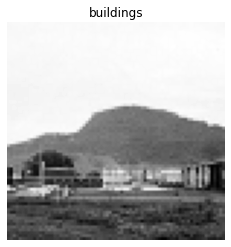

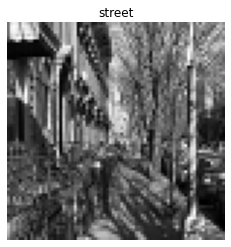

In [3]:
# ================================================================================
# FUNCTION: files_to_Xy( file_list , desired_shape )
# ================================================================================
# 
# Input: 
#   - file_list: list of filepaths to be read (as generated in the previous cell)
#   - desired_shape (optional): dimensions to transform the image data into
#        * default = (75,75): a 75x75 grayscale image
#
# Output:
#   - Numpy array of shape (n,h,w,c) containing every image present in the list
#        * n = number of images listed to be read
#        * h = first dimension of desired_shape: height of image 
#        * w = second dimension of desired_shape: width of image
#        * c = third dimension of desired_shape: number of channels in the image (gray=1)
#
# Task:
#   1. Iterate over the file list
#   2. Parse the y label for the image out of the file path
#   3. Use OpenCV (cv2) to read the image data and reshape appropriately
#   4. store the image data/label into numpy arrays of the desired shape
#   5. return the populated X and y after finished iterating
#
# ================================================================================
def files_to_Xy( file_list , desired_shape=(75,75) ):
    
    # === Setup Variables === #
    X = np.empty( (len( file_list ), desired_shape[0], desired_shape[1] ) , dtype=np.float32 )
    y = np.empty( len( file_list ) , dtype=object )
    
    # === Iterate Files === #
    for i in range( len( file_list ) ):
        y[i] = file_list[i].split( '/' )[4]
        X[i] = cv2.resize( 
                    cv2.imread( file_list[i] , cv2.IMREAD_GRAYSCALE ), 
                    ( desired_shape[0] , desired_shape[1] ) 
                ) / 255
        
    # === Return Results === #
    return X.reshape( X.shape[0] , X.shape[1], X.shape[2], 1 ) , y



# ================================================================================
# FUNCTION: show_image( X , y , idx )
# ================================================================================
#
# Input:
#   - X: numpy array containing the image data
#   - y: numpy array containing the corresponding class labels
#   - idx: index of the image to be shown
#
# Output:
#   - no return
#   - matplotlib imshow figure displayed
#
# Task:
#   1. using matplotlib.pyplot.imshow() to display the specified image
#
# Note:
#   - This function is not necessary for program completion, but it serves as a 
#     utility function to help demonstrate the success of the other necessary 
#     functions. 
#
# ================================================================================
def show_image( X , y , idx ):
    plt.figure( )
    plt.axis( 'off' )
    plt.imshow( X[idx] , cmap='gray' )
    plt.title( y[idx] )
    plt.show( )
        
        
        
# === Use Function to Get Train/Test Data === #
start             = default_timer( )
X_train , y_train = files_to_Xy( training_files )
X_test  , y_test  = files_to_Xy( testing_files  )
end               = default_timer( )
times.append( { 'Event': 'Load/Process Dataset' , 'Time (sec)': end - start } )



# === Show First and Last Images and Classes as Proof === #
show_image( X_train , y_train , 0 )
show_image( X_train , y_train , y_train.shape[0] - 1 )

## Shuffle the Training Data

Shuffling the training data is an important step to be performed before training any model. This helps to allow fairness in the training, and ensure the model is learning most effectively without encountering any biases due to ordering (for example, all cats are listed before all dogs currently, so the model may overfit to dogs before learning anything about cats).

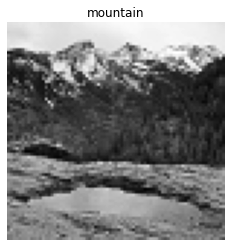

In [4]:
# === Shuffle X and y Together === #
X_train , y_train = shuffle( X_train , y_train )

# === Prove by Printing First Again to show it's Different === #
show_image( X_train , y_train , 0 )

## Convert Classes from Strings to Integers

Keras models don't handle categorical classes as well as numerical classes -- especially fora  binary classifier. Because of this, instead of having multiple class categories, we will translate the possible classes to an integer valuea. 

    Buildings --> 0
    Forest --> 1
    Glacier --> 2
    Mountain --> 3
    Sea --> 4
    Street --> 5

Finally, the builtin keras functions `keras.utils.to_categorical()` is used to translate the numbered classes into categorical representation for use in the keras model whose output is determined by softmax. This translation is performed against both the training and validation labels.

In [5]:
# === Key to Translate in Either Direction
label_keys = {
    'buildings' : 0,
    'forest'    : 1,
    'glacier'   : 2,
    'mountain'  : 3,
    'sea'       : 4,
    'street'    : 5,
    0           : 'buildings',
    1           : 'forest',
    2           : 'glacier',
    3           : 'mountain',
    4           : 'sea',
    5           : 'street'
}

# === Iteratively Translate Labels === #
for c in data_classes:
    y_train[y_train==c] = label_keys[c]
    y_test[y_test==c]   = label_keys[c]

# === Update Data Types === #
y_train = y_train.astype( X_train.dtype )
y_test  = y_test.astype( X_test.dtype )
y_train = keras.utils.to_categorical( y_train )
y_test  = keras.utils.to_categorical( y_test )

# === Prove Success === #
y_train

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

## Create Model with Tuning Options

We will be using a convolutional neural network, whose layers are specified to resemble the VGG19 model architecture. Consisting of 5 convolution blocks: 2x64, 2x128, 4x256, 4x512, 4x512. Each convolution block has a 2x2 pooling layer at the end of the block. After the five convolution blocks, the model is flattened, connected to a 1024 depth dense layer, then a dropout of 0.3, then a 64 depth dense layer, and finally a 1-depth dense layer for output. the ReLU activation function is used for all relevant layers with the exception of the output layer, which uses the softmax activation since this is a multi-class classification problem. 

In terms of tuning, we will test ten different learning rates between `1e-5` and `1e-4` in order to determine which one best converges in terms of accuracy. 

In [6]:
def model_builder( hp ):
    model_layers = [
        keras.Input( shape=X_train[0].shape , name='Input_Layer' ),
    
        keras.layers.Conv2D( 64 , kernel_size=(3,3) , activation='relu' , name='Conv_1_1' , padding='same' ),
        keras.layers.Conv2D( 64 , kernel_size=(3,3) , activation='relu' , name='Conv_1_2' , padding='same' ),
        keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_1_Pooling' ),

        keras.layers.Conv2D( 128 , kernel_size=(3,3) , activation='relu' , name='Conv_2_1' , padding='same' ),
        keras.layers.Conv2D( 128 , kernel_size=(3,3) , activation='relu' , name='Conv_2_2' , padding='same' ),
        keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_2_Pooling' ),

        keras.layers.Conv2D( 256 , kernel_size=(3,3) , activation='relu' , name='Conv_3_1' , padding='same' ),
        keras.layers.Conv2D( 256 , kernel_size=(3,3) , activation='relu' , name='Conv_3_2' , padding='same' ),
        keras.layers.Conv2D( 256 , kernel_size=(3,3) , activation='relu' , name='Conv_3_3' , padding='same' ),
        keras.layers.Conv2D( 256 , kernel_size=(3,3) , activation='relu' , name='Conv_3_4' , padding='same' ),
        keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_3_Pooling' ),

        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_4_1' , padding='same' ),
        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_4_2' , padding='same' ),
        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_4_3' , padding='same' ),
        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_4_4' , padding='same' ),
        keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_4_Pooling' ),

        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_5_1' , padding='same' ),
        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_5_2' , padding='same' ),
        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_5_3' , padding='same' ),
        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_5_4' , padding='same' ),
        keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_5_Pooling' ),

        keras.layers.Flatten( ),

        keras.layers.Dense( 1024 , activation='relu' ),
        keras.layers.Dropout( 0.3 ),

        keras.layers.Dense( 64 , activation='relu' ),
        keras.layers.Dropout( 0.3 ),

        keras.layers.Dense( len(data_classes) , activation='softmax' )
    ]
    model            = keras.Sequential( layers=model_layers )
    #hp_learning_rate = hp.Choice('learning_rate', values=list(np.linspace(0.000001, 0.00001, 10)))
    hp_learning_rate = hp.Choice('learning_rate', values=list(np.linspace(0.00001, 0.0001, 10)))
    optimizer        = keras.optimizers.Adam( lr=hp_learning_rate )
    model.compile( optimizer=optimizer , loss="categorical_crossentropy" , metrics=["accuracy"])
    return model

## Train the Model

Using the optimally found hyperparameters and a batch size of 16, train the model for 25 epochs. 

In [7]:
start      = default_timer( )
tuner      = kt.Hyperband(model_builder, objective='val_accuracy', max_epochs=10, factor=3, hyperband_iterations=10, directory=os.path.normpath('C:/Users/dryyo/Documents/keras_tuner'), project_name='SmallGrayReg' , overwrite=True)
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner.search(X_train, y_train, epochs=25, batch_size=16, validation_data=(X_test, y_test), callbacks=[stop_early])
best_hps   = tuner.get_best_hyperparameters(num_trials=1)[0]
end        = default_timer( )
times.append( { 'Event': 'Hyperparameter Tuning' , 'Time (sec)': end - start } )

print('The Optimal Leanring Rate is: {}'.format(best_hps.get('learning_rate')))

Train on 14034 samples, validate on 3000 samples
Epoch 1/2


 5072/14034 [=========>....................] - ETA: 37:07 - loss: 1.7918 - accuracy: 0.062 - ETA: 18:55 - loss: 1.7918 - accuracy: 0.125 - ETA: 9:43 - loss: 1.7917 - accuracy: 0.156 - ETA: 6:37 - loss: 1.7918 - accuracy: 0.12 - ETA: 5:47 - loss: 1.7918 - accuracy: 0.11 - ETA: 4:35 - loss: 1.7918 - accuracy: 0.13 - ETA: 3:51 - loss: 1.7917 - accuracy: 0.14 - ETA: 3:20 - loss: 1.7918 - accuracy: 0.14 - ETA: 2:57 - loss: 1.7918 - accuracy: 0.14 - ETA: 2:48 - loss: 1.7916 - accuracy: 0.14 - ETA: 2:33 - loss: 1.7917 - accuracy: 0.14 - ETA: 2:20 - loss: 1.7913 - accuracy: 0.14 - ETA: 2:10 - loss: 1.7909 - accuracy: 0.16 - ETA: 2:02 - loss: 1.7905 - accuracy: 0.16 - ETA: 1:55 - loss: 1.7907 - accuracy: 0.17 - ETA: 1:52 - loss: 1.7905 - accuracy: 0.17 - ETA: 1:46 - loss: 1.7883 - accuracy: 0.18 - ETA: 1:41 - loss: 1.7906 - accuracy: 0.18 - ETA: 1:36 - loss: 1.7927 - accuracy: 0.17 - ETA: 1:35 - loss: 1.7931 - accuracy: 0.17 - ETA: 1:31 - loss: 1.7926 - accuracy: 0.17 - ETA: 1:29 - loss: 1.7928

14034/14034 [==============================] - ETA: 10s - loss: 1.7917 - accuracy: 0.170 - ETA: 10s - loss: 1.7917 - accuracy: 0.170 - ETA: 10s - loss: 1.7917 - accuracy: 0.170 - ETA: 10s - loss: 1.7917 - accuracy: 0.170 - ETA: 9s - loss: 1.7917 - accuracy: 0.170 - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 9s - loss: 1.7916 - accuracy: 0.17 - ETA: 9s - loss: 1.7916 - accuracy: 0.17 - ETA: 9s - loss: 1.7916 - accuracy: 0.17 - ETA: 9s - loss: 1.7916 - accuracy: 0.17 - ETA: 9s - loss: 1.7916 - accuracy: 0.17 - ETA: 9s - loss: 1.7916 - accuracy: 0.17 - ETA: 8s - loss: 1.7916 - accuracy: 0.17 - ETA: 8s - loss: 1.7916 - accuracy: 0.17 - ETA: 8s - loss: 1.7916 - accuracy: 0.17 - ETA: 8s - loss: 1.7916 - accuracy: 0.17 - ETA: 8s - loss: 1.79

 5232/14034 [==========>...................] - ETA: 34s - loss: 1.7844 - accuracy: 0.062 - ETA: 32s - loss: 1.7833 - accuracy: 0.166 - ETA: 33s - loss: 1.7858 - accuracy: 0.175 - ETA: 32s - loss: 1.7873 - accuracy: 0.187 - ETA: 33s - loss: 1.7874 - accuracy: 0.187 - ETA: 32s - loss: 1.7892 - accuracy: 0.193 - ETA: 33s - loss: 1.7899 - accuracy: 0.177 - ETA: 33s - loss: 1.7904 - accuracy: 0.169 - ETA: 32s - loss: 1.7908 - accuracy: 0.168 - ETA: 33s - loss: 1.7898 - accuracy: 0.169 - ETA: 32s - loss: 1.7920 - accuracy: 0.161 - ETA: 32s - loss: 1.7916 - accuracy: 0.160 - ETA: 32s - loss: 1.7914 - accuracy: 0.163 - ETA: 32s - loss: 1.7915 - accuracy: 0.162 - ETA: 32s - loss: 1.7914 - accuracy: 0.161 - ETA: 32s - loss: 1.7923 - accuracy: 0.154 - ETA: 32s - loss: 1.7934 - accuracy: 0.152 - ETA: 32s - loss: 1.7934 - accuracy: 0.156 - ETA: 32s - loss: 1.7933 - accuracy: 0.159 - ETA: 32s - loss: 1.7927 - accuracy: 0.159 - ETA: 32s - loss: 1.7927 - accuracy: 0.158 - ETA: 32s - loss: 1.7929 - acc

14034/14034 [==============================] - ETA: 8s - loss: 1.7913 - accuracy: 0.17 - ETA: 8s - loss: 1.7913 - accuracy: 0.17 - ETA: 8s - loss: 1.7913 - accuracy: 0.17 - ETA: 8s - loss: 1.7913 - accuracy: 0.17 - ETA: 8s - loss: 1.7913 - accuracy: 0.17 - ETA: 8s - loss: 1.7913 - accuracy: 0.17 - ETA: 8s - loss: 1.7913 - accuracy: 0.17 - ETA: 8s - loss: 1.7912 - accuracy: 0.17 - ETA: 8s - loss: 1.7913 - accuracy: 0.17 - ETA: 8s - loss: 1.7913 - accuracy: 0.17 - ETA: 8s - loss: 1.7912 - accuracy: 0.17 - ETA: 8s - loss: 1.7912 - accuracy: 0.17 - ETA: 8s - loss: 1.7912 - accuracy: 0.17 - ETA: 8s - loss: 1.7912 - accuracy: 0.17 - ETA: 8s - loss: 1.7912 - accuracy: 0.17 - ETA: 7s - loss: 1.7912 - accuracy: 0.17 - ETA: 7s - loss: 1.7912 - accuracy: 0.17 - ETA: 7s - loss: 1.7912 - accuracy: 0.17 - ETA: 7s - loss: 1.7913 - accuracy: 0.17 - ETA: 7s - loss: 1.7913 - accuracy: 0.17 - ETA: 7s - loss: 1.7913 - accuracy: 0.17 - ETA: 7s - loss: 1.7913 - accuracy: 0.17 - ETA: 7s - loss: 1.7913 - accu

Train on 14034 samples, validate on 3000 samples
Epoch 1/2


 5328/14034 [==========>...................] - ETA: 12:09 - loss: 1.7918 - accuracy: 0.125 - ETA: 4:28 - loss: 1.7918 - accuracy: 0.166 - ETA: 2:56 - loss: 1.7918 - accuracy: 0.17 - ETA: 2:17 - loss: 1.7918 - accuracy: 0.13 - ETA: 1:53 - loss: 1.7918 - accuracy: 0.16 - ETA: 1:39 - loss: 1.7918 - accuracy: 0.15 - ETA: 1:34 - loss: 1.7918 - accuracy: 0.16 - ETA: 1:26 - loss: 1.7918 - accuracy: 0.16 - ETA: 1:20 - loss: 1.7918 - accuracy: 0.17 - ETA: 1:15 - loss: 1.7918 - accuracy: 0.16 - ETA: 1:11 - loss: 1.7918 - accuracy: 0.16 - ETA: 1:07 - loss: 1.7918 - accuracy: 0.16 - ETA: 1:06 - loss: 1.7918 - accuracy: 0.16 - ETA: 1:03 - loss: 1.7918 - accuracy: 0.17 - ETA: 1:01 - loss: 1.7918 - accuracy: 0.16 - ETA: 59s - loss: 1.7918 - accuracy: 0.1703 - ETA: 57s - loss: 1.7918 - accuracy: 0.165 - ETA: 56s - loss: 1.7917 - accuracy: 0.168 - ETA: 54s - loss: 1.7917 - accuracy: 0.169 - ETA: 53s - loss: 1.7917 - accuracy: 0.167 - ETA: 52s - loss: 1.7917 - accuracy: 0.174 - ETA: 51s - loss: 1.7917 -

14034/14034 [==============================] - ETA: 9s - loss: 1.4797 - accuracy: 0.35 - ETA: 9s - loss: 1.4795 - accuracy: 0.35 - ETA: 9s - loss: 1.4792 - accuracy: 0.35 - ETA: 9s - loss: 1.4780 - accuracy: 0.35 - ETA: 9s - loss: 1.4776 - accuracy: 0.35 - ETA: 9s - loss: 1.4764 - accuracy: 0.36 - ETA: 9s - loss: 1.4750 - accuracy: 0.36 - ETA: 9s - loss: 1.4740 - accuracy: 0.36 - ETA: 9s - loss: 1.4734 - accuracy: 0.36 - ETA: 9s - loss: 1.4729 - accuracy: 0.36 - ETA: 8s - loss: 1.4717 - accuracy: 0.36 - ETA: 8s - loss: 1.4705 - accuracy: 0.36 - ETA: 8s - loss: 1.4704 - accuracy: 0.36 - ETA: 8s - loss: 1.4707 - accuracy: 0.36 - ETA: 8s - loss: 1.4701 - accuracy: 0.36 - ETA: 8s - loss: 1.4697 - accuracy: 0.36 - ETA: 8s - loss: 1.4695 - accuracy: 0.36 - ETA: 8s - loss: 1.4688 - accuracy: 0.36 - ETA: 8s - loss: 1.4686 - accuracy: 0.36 - ETA: 8s - loss: 1.4675 - accuracy: 0.36 - ETA: 8s - loss: 1.4672 - accuracy: 0.36 - ETA: 8s - loss: 1.4671 - accuracy: 0.36 - ETA: 8s - loss: 1.4667 - accu

 4944/14034 [=========>....................] - ETA: 35s - loss: 0.9625 - accuracy: 0.562 - ETA: 30s - loss: 1.1257 - accuracy: 0.541 - ETA: 34s - loss: 1.1525 - accuracy: 0.531 - ETA: 32s - loss: 1.0932 - accuracy: 0.552 - ETA: 34s - loss: 1.1340 - accuracy: 0.562 - ETA: 34s - loss: 1.1035 - accuracy: 0.576 - ETA: 34s - loss: 1.1145 - accuracy: 0.573 - ETA: 35s - loss: 1.1126 - accuracy: 0.578 - ETA: 34s - loss: 1.1473 - accuracy: 0.553 - ETA: 35s - loss: 1.1497 - accuracy: 0.545 - ETA: 35s - loss: 1.1523 - accuracy: 0.555 - ETA: 34s - loss: 1.1502 - accuracy: 0.552 - ETA: 35s - loss: 1.1388 - accuracy: 0.559 - ETA: 34s - loss: 1.1508 - accuracy: 0.551 - ETA: 35s - loss: 1.1454 - accuracy: 0.554 - ETA: 34s - loss: 1.1506 - accuracy: 0.542 - ETA: 34s - loss: 1.1514 - accuracy: 0.540 - ETA: 34s - loss: 1.1765 - accuracy: 0.529 - ETA: 34s - loss: 1.1760 - accuracy: 0.525 - ETA: 34s - loss: 1.1829 - accuracy: 0.523 - ETA: 34s - loss: 1.1922 - accuracy: 0.520 - ETA: 34s - loss: 1.1849 - acc

14034/14034 [==============================] - ETA: 10s - loss: 1.1265 - accuracy: 0.550 - ETA: 10s - loss: 1.1266 - accuracy: 0.550 - ETA: 10s - loss: 1.1271 - accuracy: 0.550 - ETA: 10s - loss: 1.1276 - accuracy: 0.549 - ETA: 10s - loss: 1.1277 - accuracy: 0.549 - ETA: 10s - loss: 1.1280 - accuracy: 0.549 - ETA: 10s - loss: 1.1274 - accuracy: 0.549 - ETA: 10s - loss: 1.1277 - accuracy: 0.549 - ETA: 10s - loss: 1.1277 - accuracy: 0.549 - ETA: 10s - loss: 1.1283 - accuracy: 0.549 - ETA: 9s - loss: 1.1286 - accuracy: 0.549 - ETA: 9s - loss: 1.1283 - accuracy: 0.54 - ETA: 9s - loss: 1.1277 - accuracy: 0.54 - ETA: 9s - loss: 1.1273 - accuracy: 0.55 - ETA: 9s - loss: 1.1272 - accuracy: 0.55 - ETA: 9s - loss: 1.1269 - accuracy: 0.55 - ETA: 9s - loss: 1.1266 - accuracy: 0.55 - ETA: 9s - loss: 1.1259 - accuracy: 0.55 - ETA: 9s - loss: 1.1268 - accuracy: 0.55 - ETA: 9s - loss: 1.1265 - accuracy: 0.55 - ETA: 9s - loss: 1.1263 - accuracy: 0.55 - ETA: 9s - loss: 1.1272 - accuracy: 0.55 - ETA: 8s 

Train on 14034 samples, validate on 3000 samples
Epoch 1/2


 4816/14034 [=========>....................] - ETA: 12:40 - loss: 1.7918 - accuracy: 0.062 - ETA: 4:36 - loss: 1.7918 - accuracy: 0.187 - ETA: 3:39 - loss: 1.7917 - accuracy: 0.20 - ETA: 2:37 - loss: 1.7918 - accuracy: 0.18 - ETA: 2:21 - loss: 1.7918 - accuracy: 0.17 - ETA: 1:57 - loss: 1.7919 - accuracy: 0.15 - ETA: 1:49 - loss: 1.7919 - accuracy: 0.14 - ETA: 1:36 - loss: 1.7919 - accuracy: 0.13 - ETA: 1:32 - loss: 1.7920 - accuracy: 0.13 - ETA: 1:24 - loss: 1.7920 - accuracy: 0.13 - ETA: 1:18 - loss: 1.7920 - accuracy: 0.13 - ETA: 1:16 - loss: 1.7920 - accuracy: 0.14 - ETA: 1:11 - loss: 1.7919 - accuracy: 0.15 - ETA: 1:10 - loss: 1.7919 - accuracy: 0.14 - ETA: 1:07 - loss: 1.7919 - accuracy: 0.15 - ETA: 1:04 - loss: 1.7919 - accuracy: 0.15 - ETA: 1:01 - loss: 1.7919 - accuracy: 0.16 - ETA: 1:01 - loss: 1.7918 - accuracy: 0.16 - ETA: 59s - loss: 1.7918 - accuracy: 0.1667 - ETA: 58s - loss: 1.7919 - accuracy: 0.167 - ETA: 56s - loss: 1.7919 - accuracy: 0.170 - ETA: 56s - loss: 1.7918 -

14034/14034 [==============================] - ETA: 11s - loss: 1.7916 - accuracy: 0.177 - ETA: 11s - loss: 1.7916 - accuracy: 0.177 - ETA: 11s - loss: 1.7916 - accuracy: 0.177 - ETA: 11s - loss: 1.7916 - accuracy: 0.177 - ETA: 10s - loss: 1.7916 - accuracy: 0.177 - ETA: 10s - loss: 1.7916 - accuracy: 0.177 - ETA: 10s - loss: 1.7916 - accuracy: 0.177 - ETA: 10s - loss: 1.7916 - accuracy: 0.177 - ETA: 10s - loss: 1.7916 - accuracy: 0.177 - ETA: 10s - loss: 1.7916 - accuracy: 0.177 - ETA: 10s - loss: 1.7916 - accuracy: 0.177 - ETA: 10s - loss: 1.7916 - accuracy: 0.177 - ETA: 10s - loss: 1.7916 - accuracy: 0.177 - ETA: 10s - loss: 1.7916 - accuracy: 0.178 - ETA: 10s - loss: 1.7916 - accuracy: 0.178 - ETA: 10s - loss: 1.7916 - accuracy: 0.178 - ETA: 10s - loss: 1.7916 - accuracy: 0.178 - ETA: 10s - loss: 1.7916 - accuracy: 0.178 - ETA: 10s - loss: 1.7915 - accuracy: 0.178 - ETA: 9s - loss: 1.7915 - accuracy: 0.178 - ETA: 9s - loss: 1.7915 - accuracy: 0.17 - ETA: 9s - loss: 1.7915 - accurac

 5152/14034 [==========>...................] - ETA: 38s - loss: 1.7966 - accuracy: 0.062 - ETA: 37s - loss: 1.7935 - accuracy: 0.083 - ETA: 37s - loss: 1.7926 - accuracy: 0.137 - ETA: 36s - loss: 1.7923 - accuracy: 0.133 - ETA: 36s - loss: 1.7929 - accuracy: 0.131 - ETA: 36s - loss: 1.7936 - accuracy: 0.142 - ETA: 36s - loss: 1.7921 - accuracy: 0.153 - ETA: 35s - loss: 1.7916 - accuracy: 0.150 - ETA: 35s - loss: 1.7915 - accuracy: 0.158 - ETA: 35s - loss: 1.7919 - accuracy: 0.151 - ETA: 35s - loss: 1.7913 - accuracy: 0.154 - ETA: 35s - loss: 1.7909 - accuracy: 0.153 - ETA: 34s - loss: 1.7910 - accuracy: 0.158 - ETA: 35s - loss: 1.7908 - accuracy: 0.157 - ETA: 35s - loss: 1.7910 - accuracy: 0.159 - ETA: 35s - loss: 1.7916 - accuracy: 0.159 - ETA: 35s - loss: 1.7918 - accuracy: 0.162 - ETA: 35s - loss: 1.7914 - accuracy: 0.169 - ETA: 35s - loss: 1.7911 - accuracy: 0.176 - ETA: 35s - loss: 1.7908 - accuracy: 0.177 - ETA: 35s - loss: 1.7908 - accuracy: 0.172 - ETA: 35s - loss: 1.7902 - acc

14034/14034 [==============================] - ETA: 9s - loss: 1.7910 - accuracy: 0.17 - ETA: 9s - loss: 1.7910 - accuracy: 0.17 - ETA: 9s - loss: 1.7910 - accuracy: 0.17 - ETA: 9s - loss: 1.7910 - accuracy: 0.17 - ETA: 9s - loss: 1.7910 - accuracy: 0.17 - ETA: 9s - loss: 1.7910 - accuracy: 0.17 - ETA: 9s - loss: 1.7911 - accuracy: 0.17 - ETA: 9s - loss: 1.7910 - accuracy: 0.17 - ETA: 9s - loss: 1.7910 - accuracy: 0.17 - ETA: 9s - loss: 1.7910 - accuracy: 0.17 - ETA: 9s - loss: 1.7910 - accuracy: 0.17 - ETA: 8s - loss: 1.7910 - accuracy: 0.17 - ETA: 8s - loss: 1.7910 - accuracy: 0.17 - ETA: 8s - loss: 1.7910 - accuracy: 0.17 - ETA: 8s - loss: 1.7910 - accuracy: 0.17 - ETA: 8s - loss: 1.7910 - accuracy: 0.17 - ETA: 8s - loss: 1.7910 - accuracy: 0.17 - ETA: 8s - loss: 1.7910 - accuracy: 0.17 - ETA: 8s - loss: 1.7910 - accuracy: 0.17 - ETA: 8s - loss: 1.7910 - accuracy: 0.17 - ETA: 8s - loss: 1.7910 - accuracy: 0.17 - ETA: 8s - loss: 1.7910 - accuracy: 0.17 - ETA: 8s - loss: 1.7910 - accu

Train on 14034 samples, validate on 3000 samples
Epoch 1/2


 5248/14034 [==========>...................] - ETA: 12:08 - loss: 1.7917 - accuracy: 0.187 - ETA: 4:22 - loss: 1.7917 - accuracy: 0.187 - ETA: 3:28 - loss: 1.7917 - accuracy: 0.17 - ETA: 2:28 - loss: 1.7918 - accuracy: 0.15 - ETA: 2:13 - loss: 1.7918 - accuracy: 0.16 - ETA: 1:50 - loss: 1.7918 - accuracy: 0.18 - ETA: 1:43 - loss: 1.7918 - accuracy: 0.18 - ETA: 1:30 - loss: 1.7918 - accuracy: 0.17 - ETA: 1:27 - loss: 1.7918 - accuracy: 0.16 - ETA: 1:20 - loss: 1.7918 - accuracy: 0.16 - ETA: 1:14 - loss: 1.7918 - accuracy: 0.16 - ETA: 1:12 - loss: 1.7917 - accuracy: 0.16 - ETA: 1:08 - loss: 1.7917 - accuracy: 0.15 - ETA: 1:07 - loss: 1.7917 - accuracy: 0.16 - ETA: 1:04 - loss: 1.7917 - accuracy: 0.16 - ETA: 1:01 - loss: 1.7917 - accuracy: 0.17 - ETA: 1:00 - loss: 1.7917 - accuracy: 0.17 - ETA: 58s - loss: 1.7917 - accuracy: 0.1786 - ETA: 57s - loss: 1.7917 - accuracy: 0.176 - ETA: 55s - loss: 1.7917 - accuracy: 0.173 - ETA: 55s - loss: 1.7917 - accuracy: 0.168 - ETA: 54s - loss: 1.7917 -

14034/14034 [==============================] - ETA: 9s - loss: 1.5128 - accuracy: 0.33 - ETA: 9s - loss: 1.5118 - accuracy: 0.34 - ETA: 9s - loss: 1.5105 - accuracy: 0.34 - ETA: 9s - loss: 1.5105 - accuracy: 0.34 - ETA: 9s - loss: 1.5097 - accuracy: 0.34 - ETA: 9s - loss: 1.5094 - accuracy: 0.34 - ETA: 8s - loss: 1.5088 - accuracy: 0.34 - ETA: 8s - loss: 1.5083 - accuracy: 0.34 - ETA: 8s - loss: 1.5076 - accuracy: 0.34 - ETA: 8s - loss: 1.5070 - accuracy: 0.34 - ETA: 8s - loss: 1.5061 - accuracy: 0.34 - ETA: 8s - loss: 1.5058 - accuracy: 0.34 - ETA: 8s - loss: 1.5051 - accuracy: 0.34 - ETA: 8s - loss: 1.5049 - accuracy: 0.34 - ETA: 8s - loss: 1.5036 - accuracy: 0.34 - ETA: 8s - loss: 1.5029 - accuracy: 0.34 - ETA: 8s - loss: 1.5023 - accuracy: 0.34 - ETA: 8s - loss: 1.5018 - accuracy: 0.34 - ETA: 8s - loss: 1.5019 - accuracy: 0.34 - ETA: 8s - loss: 1.5019 - accuracy: 0.34 - ETA: 7s - loss: 1.5012 - accuracy: 0.34 - ETA: 7s - loss: 1.5007 - accuracy: 0.34 - ETA: 7s - loss: 1.4995 - accu

 4848/14034 [=========>....................] - ETA: 39s - loss: 1.4096 - accuracy: 0.375 - ETA: 35s - loss: 1.3263 - accuracy: 0.416 - ETA: 34s - loss: 1.2729 - accuracy: 0.437 - ETA: 36s - loss: 1.2832 - accuracy: 0.416 - ETA: 34s - loss: 1.3239 - accuracy: 0.406 - ETA: 36s - loss: 1.3855 - accuracy: 0.402 - ETA: 35s - loss: 1.3635 - accuracy: 0.426 - ETA: 35s - loss: 1.3583 - accuracy: 0.437 - ETA: 35s - loss: 1.3237 - accuracy: 0.445 - ETA: 35s - loss: 1.3293 - accuracy: 0.441 - ETA: 34s - loss: 1.3305 - accuracy: 0.444 - ETA: 35s - loss: 1.3138 - accuracy: 0.450 - ETA: 35s - loss: 1.3048 - accuracy: 0.467 - ETA: 35s - loss: 1.3107 - accuracy: 0.464 - ETA: 35s - loss: 1.3049 - accuracy: 0.468 - ETA: 35s - loss: 1.2991 - accuracy: 0.478 - ETA: 35s - loss: 1.2927 - accuracy: 0.483 - ETA: 35s - loss: 1.2938 - accuracy: 0.484 - ETA: 35s - loss: 1.2816 - accuracy: 0.494 - ETA: 35s - loss: 1.2887 - accuracy: 0.490 - ETA: 35s - loss: 1.2889 - accuracy: 0.490 - ETA: 35s - loss: 1.2761 - acc

14034/14034 [==============================] - ETA: 11s - loss: 1.1778 - accuracy: 0.524 - ETA: 11s - loss: 1.1774 - accuracy: 0.524 - ETA: 11s - loss: 1.1777 - accuracy: 0.524 - ETA: 11s - loss: 1.1770 - accuracy: 0.524 - ETA: 11s - loss: 1.1766 - accuracy: 0.524 - ETA: 11s - loss: 1.1760 - accuracy: 0.525 - ETA: 11s - loss: 1.1751 - accuracy: 0.525 - ETA: 10s - loss: 1.1759 - accuracy: 0.524 - ETA: 10s - loss: 1.1758 - accuracy: 0.524 - ETA: 10s - loss: 1.1752 - accuracy: 0.524 - ETA: 10s - loss: 1.1749 - accuracy: 0.524 - ETA: 10s - loss: 1.1751 - accuracy: 0.524 - ETA: 10s - loss: 1.1750 - accuracy: 0.525 - ETA: 10s - loss: 1.1744 - accuracy: 0.525 - ETA: 10s - loss: 1.1746 - accuracy: 0.524 - ETA: 10s - loss: 1.1743 - accuracy: 0.524 - ETA: 10s - loss: 1.1751 - accuracy: 0.524 - ETA: 10s - loss: 1.1744 - accuracy: 0.525 - ETA: 10s - loss: 1.1747 - accuracy: 0.525 - ETA: 10s - loss: 1.1742 - accuracy: 0.525 - ETA: 10s - loss: 1.1745 - accuracy: 0.525 - ETA: 9s - loss: 1.1743 - accu

Train on 14034 samples, validate on 3000 samples
Epoch 1/2


 5328/14034 [==========>...................] - ETA: 12:27 - loss: 1.7918 - accuracy: 0.187 - ETA: 4:35 - loss: 1.7918 - accuracy: 0.187 - ETA: 3:00 - loss: 1.7917 - accuracy: 0.13 - ETA: 2:19 - loss: 1.7917 - accuracy: 0.16 - ETA: 1:56 - loss: 1.7917 - accuracy: 0.16 - ETA: 1:41 - loss: 1.7917 - accuracy: 0.15 - ETA: 1:31 - loss: 1.7916 - accuracy: 0.16 - ETA: 1:23 - loss: 1.7916 - accuracy: 0.15 - ETA: 1:17 - loss: 1.7915 - accuracy: 0.15 - ETA: 1:13 - loss: 1.7915 - accuracy: 0.14 - ETA: 1:09 - loss: 1.7915 - accuracy: 0.15 - ETA: 1:06 - loss: 1.7915 - accuracy: 0.15 - ETA: 1:04 - loss: 1.7912 - accuracy: 0.15 - ETA: 1:01 - loss: 1.7913 - accuracy: 0.16 - ETA: 59s - loss: 1.7915 - accuracy: 0.1616 - ETA: 58s - loss: 1.7915 - accuracy: 0.159 - ETA: 56s - loss: 1.7918 - accuracy: 0.157 - ETA: 55s - loss: 1.7912 - accuracy: 0.164 - ETA: 54s - loss: 1.7911 - accuracy: 0.167 - ETA: 52s - loss: 1.7909 - accuracy: 0.173 - ETA: 51s - loss: 1.7911 - accuracy: 0.172 - ETA: 51s - loss: 1.7913 -

14034/14034 [==============================] - ETA: 10s - loss: 1.4418 - accuracy: 0.386 - ETA: 10s - loss: 1.4414 - accuracy: 0.386 - ETA: 10s - loss: 1.4412 - accuracy: 0.386 - ETA: 9s - loss: 1.4400 - accuracy: 0.387 - ETA: 9s - loss: 1.4403 - accuracy: 0.38 - ETA: 9s - loss: 1.4400 - accuracy: 0.38 - ETA: 9s - loss: 1.4394 - accuracy: 0.38 - ETA: 9s - loss: 1.4387 - accuracy: 0.38 - ETA: 9s - loss: 1.4380 - accuracy: 0.38 - ETA: 9s - loss: 1.4372 - accuracy: 0.38 - ETA: 9s - loss: 1.4379 - accuracy: 0.38 - ETA: 9s - loss: 1.4369 - accuracy: 0.38 - ETA: 9s - loss: 1.4362 - accuracy: 0.38 - ETA: 9s - loss: 1.4359 - accuracy: 0.38 - ETA: 9s - loss: 1.4364 - accuracy: 0.38 - ETA: 9s - loss: 1.4363 - accuracy: 0.38 - ETA: 8s - loss: 1.4359 - accuracy: 0.38 - ETA: 8s - loss: 1.4345 - accuracy: 0.38 - ETA: 8s - loss: 1.4339 - accuracy: 0.38 - ETA: 8s - loss: 1.4332 - accuracy: 0.38 - ETA: 8s - loss: 1.4323 - accuracy: 0.39 - ETA: 8s - loss: 1.4308 - accuracy: 0.39 - ETA: 8s - loss: 1.4302

 4912/14034 [=========>....................] - ETA: 37s - loss: 1.0746 - accuracy: 0.687 - ETA: 32s - loss: 1.1324 - accuracy: 0.583 - ETA: 36s - loss: 1.3249 - accuracy: 0.515 - ETA: 33s - loss: 1.2201 - accuracy: 0.531 - ETA: 35s - loss: 1.1628 - accuracy: 0.571 - ETA: 35s - loss: 1.2487 - accuracy: 0.548 - ETA: 36s - loss: 1.2282 - accuracy: 0.543 - ETA: 34s - loss: 1.2441 - accuracy: 0.515 - ETA: 35s - loss: 1.2476 - accuracy: 0.514 - ETA: 35s - loss: 1.2222 - accuracy: 0.512 - ETA: 35s - loss: 1.2286 - accuracy: 0.507 - ETA: 36s - loss: 1.2257 - accuracy: 0.513 - ETA: 35s - loss: 1.2289 - accuracy: 0.518 - ETA: 35s - loss: 1.2334 - accuracy: 0.514 - ETA: 35s - loss: 1.2236 - accuracy: 0.516 - ETA: 35s - loss: 1.2290 - accuracy: 0.515 - ETA: 35s - loss: 1.2165 - accuracy: 0.521 - ETA: 35s - loss: 1.2274 - accuracy: 0.513 - ETA: 35s - loss: 1.2176 - accuracy: 0.510 - ETA: 34s - loss: 1.2171 - accuracy: 0.507 - ETA: 35s - loss: 1.2114 - accuracy: 0.513 - ETA: 34s - loss: 1.2047 - acc

14034/14034 [==============================] - ETA: 11s - loss: 1.0918 - accuracy: 0.564 - ETA: 11s - loss: 1.0923 - accuracy: 0.564 - ETA: 10s - loss: 1.0911 - accuracy: 0.564 - ETA: 10s - loss: 1.0915 - accuracy: 0.564 - ETA: 10s - loss: 1.0918 - accuracy: 0.563 - ETA: 10s - loss: 1.0915 - accuracy: 0.564 - ETA: 10s - loss: 1.0910 - accuracy: 0.564 - ETA: 10s - loss: 1.0912 - accuracy: 0.564 - ETA: 10s - loss: 1.0902 - accuracy: 0.564 - ETA: 10s - loss: 1.0907 - accuracy: 0.564 - ETA: 10s - loss: 1.0911 - accuracy: 0.564 - ETA: 10s - loss: 1.0911 - accuracy: 0.564 - ETA: 10s - loss: 1.0918 - accuracy: 0.564 - ETA: 10s - loss: 1.0915 - accuracy: 0.564 - ETA: 10s - loss: 1.0919 - accuracy: 0.564 - ETA: 10s - loss: 1.0917 - accuracy: 0.564 - ETA: 10s - loss: 1.0916 - accuracy: 0.564 - ETA: 9s - loss: 1.0909 - accuracy: 0.564 - ETA: 9s - loss: 1.0913 - accuracy: 0.56 - ETA: 9s - loss: 1.0915 - accuracy: 0.56 - ETA: 9s - loss: 1.0920 - accuracy: 0.56 - ETA: 9s - loss: 1.0917 - accuracy: 0

Train on 14034 samples, validate on 3000 samples
Epoch 1/2


 4864/14034 [=========>....................] - ETA: 12:01 - loss: 1.7917 - accuracy: 0.250 - ETA: 4:21 - loss: 1.7918 - accuracy: 0.145 - ETA: 3:27 - loss: 1.7916 - accuracy: 0.17 - ETA: 2:30 - loss: 1.7917 - accuracy: 0.14 - ETA: 2:00 - loss: 1.7919 - accuracy: 0.15 - ETA: 1:43 - loss: 1.7920 - accuracy: 0.15 - ETA: 1:31 - loss: 1.7922 - accuracy: 0.15 - ETA: 1:27 - loss: 1.7922 - accuracy: 0.14 - ETA: 1:19 - loss: 1.7922 - accuracy: 0.15 - ETA: 1:17 - loss: 1.7922 - accuracy: 0.14 - ETA: 1:12 - loss: 1.7921 - accuracy: 0.14 - ETA: 1:10 - loss: 1.7921 - accuracy: 0.14 - ETA: 1:07 - loss: 1.7922 - accuracy: 0.14 - ETA: 1:04 - loss: 1.7922 - accuracy: 0.14 - ETA: 1:01 - loss: 1.7921 - accuracy: 0.14 - ETA: 59s - loss: 1.7920 - accuracy: 0.1458 - ETA: 58s - loss: 1.7920 - accuracy: 0.145 - ETA: 56s - loss: 1.7921 - accuracy: 0.143 - ETA: 56s - loss: 1.7920 - accuracy: 0.147 - ETA: 54s - loss: 1.7919 - accuracy: 0.153 - ETA: 53s - loss: 1.7919 - accuracy: 0.153 - ETA: 52s - loss: 1.7920 -

14034/14034 [==============================] - ETA: 10s - loss: 1.7092 - accuracy: 0.209 - ETA: 10s - loss: 1.7080 - accuracy: 0.210 - ETA: 10s - loss: 1.7075 - accuracy: 0.210 - ETA: 10s - loss: 1.7066 - accuracy: 0.211 - ETA: 10s - loss: 1.7055 - accuracy: 0.211 - ETA: 10s - loss: 1.7054 - accuracy: 0.211 - ETA: 10s - loss: 1.7043 - accuracy: 0.211 - ETA: 10s - loss: 1.7035 - accuracy: 0.212 - ETA: 10s - loss: 1.7022 - accuracy: 0.212 - ETA: 10s - loss: 1.7012 - accuracy: 0.213 - ETA: 10s - loss: 1.7000 - accuracy: 0.213 - ETA: 9s - loss: 1.6993 - accuracy: 0.213 - ETA: 9s - loss: 1.6979 - accuracy: 0.21 - ETA: 9s - loss: 1.6971 - accuracy: 0.21 - ETA: 9s - loss: 1.6958 - accuracy: 0.21 - ETA: 9s - loss: 1.6950 - accuracy: 0.21 - ETA: 9s - loss: 1.6936 - accuracy: 0.21 - ETA: 9s - loss: 1.6927 - accuracy: 0.21 - ETA: 9s - loss: 1.6917 - accuracy: 0.21 - ETA: 9s - loss: 1.6911 - accuracy: 0.21 - ETA: 9s - loss: 1.6910 - accuracy: 0.21 - ETA: 9s - loss: 1.6893 - accuracy: 0.21 - ETA: 9

 4992/14034 [=========>....................] - ETA: 38s - loss: 1.2248 - accuracy: 0.437 - ETA: 33s - loss: 1.4516 - accuracy: 0.354 - ETA: 36s - loss: 1.4811 - accuracy: 0.359 - ETA: 34s - loss: 1.5998 - accuracy: 0.343 - ETA: 36s - loss: 1.5684 - accuracy: 0.357 - ETA: 35s - loss: 1.4666 - accuracy: 0.402 - ETA: 35s - loss: 1.4616 - accuracy: 0.420 - ETA: 35s - loss: 1.4910 - accuracy: 0.408 - ETA: 35s - loss: 1.4966 - accuracy: 0.397 - ETA: 34s - loss: 1.4602 - accuracy: 0.402 - ETA: 35s - loss: 1.4497 - accuracy: 0.397 - ETA: 34s - loss: 1.4296 - accuracy: 0.398 - ETA: 35s - loss: 1.4255 - accuracy: 0.393 - ETA: 35s - loss: 1.4142 - accuracy: 0.397 - ETA: 34s - loss: 1.4135 - accuracy: 0.401 - ETA: 34s - loss: 1.4059 - accuracy: 0.403 - ETA: 34s - loss: 1.3922 - accuracy: 0.404 - ETA: 34s - loss: 1.3862 - accuracy: 0.403 - ETA: 34s - loss: 1.3792 - accuracy: 0.395 - ETA: 34s - loss: 1.3715 - accuracy: 0.394 - ETA: 34s - loss: 1.3601 - accuracy: 0.395 - ETA: 34s - loss: 1.3501 - acc

14034/14034 [==============================] - ETA: 10s - loss: 1.2255 - accuracy: 0.447 - ETA: 10s - loss: 1.2253 - accuracy: 0.447 - ETA: 10s - loss: 1.2256 - accuracy: 0.447 - ETA: 10s - loss: 1.2255 - accuracy: 0.447 - ETA: 10s - loss: 1.2255 - accuracy: 0.447 - ETA: 10s - loss: 1.2255 - accuracy: 0.447 - ETA: 10s - loss: 1.2253 - accuracy: 0.447 - ETA: 10s - loss: 1.2259 - accuracy: 0.447 - ETA: 10s - loss: 1.2260 - accuracy: 0.447 - ETA: 9s - loss: 1.2253 - accuracy: 0.447 - ETA: 9s - loss: 1.2252 - accuracy: 0.44 - ETA: 9s - loss: 1.2250 - accuracy: 0.44 - ETA: 9s - loss: 1.2250 - accuracy: 0.44 - ETA: 9s - loss: 1.2247 - accuracy: 0.44 - ETA: 9s - loss: 1.2247 - accuracy: 0.44 - ETA: 9s - loss: 1.2241 - accuracy: 0.44 - ETA: 9s - loss: 1.2237 - accuracy: 0.44 - ETA: 9s - loss: 1.2237 - accuracy: 0.44 - ETA: 9s - loss: 1.2233 - accuracy: 0.44 - ETA: 9s - loss: 1.2234 - accuracy: 0.44 - ETA: 9s - loss: 1.2236 - accuracy: 0.44 - ETA: 9s - loss: 1.2238 - accuracy: 0.44 - ETA: 9s - 

Train on 14034 samples, validate on 3000 samples
Epoch 1/2


 4848/14034 [=========>....................] - ETA: 11:53 - loss: 1.7918 - accuracy: 0.187 - ETA: 6:19 - loss: 1.7918 - accuracy: 0.156 - ETA: 3:27 - loss: 1.7913 - accuracy: 0.18 - ETA: 2:54 - loss: 1.7914 - accuracy: 0.18 - ETA: 2:14 - loss: 1.7920 - accuracy: 0.19 - ETA: 1:51 - loss: 1.7922 - accuracy: 0.20 - ETA: 1:45 - loss: 1.7921 - accuracy: 0.20 - ETA: 1:33 - loss: 1.7919 - accuracy: 0.19 - ETA: 1:24 - loss: 1.7921 - accuracy: 0.17 - ETA: 1:21 - loss: 1.7921 - accuracy: 0.17 - ETA: 1:15 - loss: 1.7917 - accuracy: 0.18 - ETA: 1:13 - loss: 1.7917 - accuracy: 0.18 - ETA: 1:09 - loss: 1.7912 - accuracy: 0.17 - ETA: 1:06 - loss: 1.7899 - accuracy: 0.18 - ETA: 1:03 - loss: 1.7832 - accuracy: 0.19 - ETA: 1:02 - loss: 1.7879 - accuracy: 0.18 - ETA: 1:00 - loss: 1.7860 - accuracy: 0.18 - ETA: 59s - loss: 1.7858 - accuracy: 0.1786 - ETA: 57s - loss: 1.7862 - accuracy: 0.175 - ETA: 57s - loss: 1.7864 - accuracy: 0.175 - ETA: 55s - loss: 1.7867 - accuracy: 0.166 - ETA: 55s - loss: 1.7868 -

14034/14034 [==============================] - ETA: 11s - loss: 1.6168 - accuracy: 0.258 - ETA: 11s - loss: 1.6162 - accuracy: 0.258 - ETA: 11s - loss: 1.6152 - accuracy: 0.258 - ETA: 11s - loss: 1.6146 - accuracy: 0.258 - ETA: 11s - loss: 1.6136 - accuracy: 0.259 - ETA: 11s - loss: 1.6132 - accuracy: 0.259 - ETA: 10s - loss: 1.6128 - accuracy: 0.258 - ETA: 10s - loss: 1.6117 - accuracy: 0.259 - ETA: 10s - loss: 1.6112 - accuracy: 0.259 - ETA: 10s - loss: 1.6101 - accuracy: 0.259 - ETA: 10s - loss: 1.6085 - accuracy: 0.260 - ETA: 10s - loss: 1.6076 - accuracy: 0.261 - ETA: 10s - loss: 1.6069 - accuracy: 0.261 - ETA: 10s - loss: 1.6071 - accuracy: 0.261 - ETA: 10s - loss: 1.6061 - accuracy: 0.261 - ETA: 10s - loss: 1.6058 - accuracy: 0.261 - ETA: 10s - loss: 1.6042 - accuracy: 0.262 - ETA: 10s - loss: 1.6035 - accuracy: 0.262 - ETA: 10s - loss: 1.6035 - accuracy: 0.262 - ETA: 9s - loss: 1.6021 - accuracy: 0.263 - ETA: 9s - loss: 1.6017 - accuracy: 0.26 - ETA: 9s - loss: 1.6020 - accurac

 4896/14034 [=========>....................] - ETA: 38s - loss: 1.1221 - accuracy: 0.437 - ETA: 32s - loss: 1.2003 - accuracy: 0.437 - ETA: 36s - loss: 1.2830 - accuracy: 0.375 - ETA: 36s - loss: 1.2921 - accuracy: 0.385 - ETA: 35s - loss: 1.2232 - accuracy: 0.453 - ETA: 36s - loss: 1.2348 - accuracy: 0.444 - ETA: 34s - loss: 1.2074 - accuracy: 0.448 - ETA: 36s - loss: 1.2177 - accuracy: 0.442 - ETA: 35s - loss: 1.2512 - accuracy: 0.442 - ETA: 35s - loss: 1.2822 - accuracy: 0.425 - ETA: 35s - loss: 1.2863 - accuracy: 0.422 - ETA: 35s - loss: 1.2750 - accuracy: 0.424 - ETA: 35s - loss: 1.2736 - accuracy: 0.421 - ETA: 34s - loss: 1.2928 - accuracy: 0.411 - ETA: 35s - loss: 1.2926 - accuracy: 0.410 - ETA: 35s - loss: 1.2842 - accuracy: 0.410 - ETA: 34s - loss: 1.2826 - accuracy: 0.402 - ETA: 34s - loss: 1.2771 - accuracy: 0.407 - ETA: 35s - loss: 1.2737 - accuracy: 0.412 - ETA: 34s - loss: 1.2718 - accuracy: 0.412 - ETA: 34s - loss: 1.2665 - accuracy: 0.413 - ETA: 34s - loss: 1.2686 - acc

14034/14034 [==============================] - ETA: 10s - loss: 1.1958 - accuracy: 0.464 - ETA: 10s - loss: 1.1961 - accuracy: 0.463 - ETA: 10s - loss: 1.1960 - accuracy: 0.463 - ETA: 10s - loss: 1.1959 - accuracy: 0.464 - ETA: 10s - loss: 1.1965 - accuracy: 0.463 - ETA: 10s - loss: 1.1968 - accuracy: 0.463 - ETA: 10s - loss: 1.1965 - accuracy: 0.463 - ETA: 10s - loss: 1.1970 - accuracy: 0.463 - ETA: 10s - loss: 1.1971 - accuracy: 0.463 - ETA: 10s - loss: 1.1975 - accuracy: 0.463 - ETA: 10s - loss: 1.1969 - accuracy: 0.463 - ETA: 10s - loss: 1.1966 - accuracy: 0.463 - ETA: 9s - loss: 1.1965 - accuracy: 0.464 - ETA: 9s - loss: 1.1965 - accuracy: 0.46 - ETA: 9s - loss: 1.1959 - accuracy: 0.46 - ETA: 9s - loss: 1.1959 - accuracy: 0.46 - ETA: 9s - loss: 1.1959 - accuracy: 0.46 - ETA: 9s - loss: 1.1953 - accuracy: 0.46 - ETA: 9s - loss: 1.1948 - accuracy: 0.46 - ETA: 9s - loss: 1.1943 - accuracy: 0.46 - ETA: 9s - loss: 1.1937 - accuracy: 0.46 - ETA: 9s - loss: 1.1946 - accuracy: 0.46 - ETA:

Train on 14034 samples, validate on 3000 samples
Epoch 1/2


 5424/14034 [==========>...................] - ETA: 12:19 - loss: 1.7917 - accuracy: 0.125 - ETA: 4:31 - loss: 1.7916 - accuracy: 0.104 - ETA: 2:55 - loss: 1.7919 - accuracy: 0.13 - ETA: 2:33 - loss: 1.7922 - accuracy: 0.11 - ETA: 2:04 - loss: 1.7919 - accuracy: 0.16 - ETA: 1:46 - loss: 1.7918 - accuracy: 0.15 - ETA: 1:34 - loss: 1.7922 - accuracy: 0.13 - ETA: 1:26 - loss: 1.7921 - accuracy: 0.14 - ETA: 1:19 - loss: 1.7922 - accuracy: 0.14 - ETA: 1:14 - loss: 1.7923 - accuracy: 0.13 - ETA: 1:12 - loss: 1.7923 - accuracy: 0.14 - ETA: 1:08 - loss: 1.7922 - accuracy: 0.15 - ETA: 1:05 - loss: 1.7922 - accuracy: 0.15 - ETA: 1:03 - loss: 1.7921 - accuracy: 0.15 - ETA: 1:00 - loss: 1.7921 - accuracy: 0.15 - ETA: 1:00 - loss: 1.7921 - accuracy: 0.15 - ETA: 58s - loss: 1.7921 - accuracy: 0.1562 - ETA: 56s - loss: 1.7920 - accuracy: 0.158 - ETA: 55s - loss: 1.7921 - accuracy: 0.152 - ETA: 54s - loss: 1.7921 - accuracy: 0.152 - ETA: 52s - loss: 1.7921 - accuracy: 0.154 - ETA: 52s - loss: 1.7921 -

14034/14034 [==============================] - ETA: 8s - loss: 1.7917 - accuracy: 0.16 - ETA: 8s - loss: 1.7917 - accuracy: 0.16 - ETA: 8s - loss: 1.7917 - accuracy: 0.16 - ETA: 8s - loss: 1.7917 - accuracy: 0.16 - ETA: 8s - loss: 1.7917 - accuracy: 0.16 - ETA: 8s - loss: 1.7917 - accuracy: 0.16 - ETA: 8s - loss: 1.7917 - accuracy: 0.16 - ETA: 7s - loss: 1.7917 - accuracy: 0.16 - ETA: 7s - loss: 1.7917 - accuracy: 0.16 - ETA: 7s - loss: 1.7917 - accuracy: 0.16 - ETA: 7s - loss: 1.7917 - accuracy: 0.16 - ETA: 7s - loss: 1.7918 - accuracy: 0.16 - ETA: 7s - loss: 1.7918 - accuracy: 0.16 - ETA: 7s - loss: 1.7918 - accuracy: 0.16 - ETA: 7s - loss: 1.7918 - accuracy: 0.16 - ETA: 7s - loss: 1.7918 - accuracy: 0.16 - ETA: 7s - loss: 1.7918 - accuracy: 0.16 - ETA: 7s - loss: 1.7918 - accuracy: 0.16 - ETA: 7s - loss: 1.7918 - accuracy: 0.16 - ETA: 7s - loss: 1.7918 - accuracy: 0.16 - ETA: 7s - loss: 1.7918 - accuracy: 0.16 - ETA: 6s - loss: 1.7918 - accuracy: 0.16 - ETA: 6s - loss: 1.7918 - accu

 4912/14034 [=========>....................] - ETA: 36s - loss: 1.7957 - accuracy: 0.125 - ETA: 37s - loss: 1.7896 - accuracy: 0.187 - ETA: 37s - loss: 1.7896 - accuracy: 0.200 - ETA: 37s - loss: 1.7882 - accuracy: 0.223 - ETA: 36s - loss: 1.7873 - accuracy: 0.236 - ETA: 36s - loss: 1.7882 - accuracy: 0.215 - ETA: 36s - loss: 1.7885 - accuracy: 0.221 - ETA: 35s - loss: 1.7888 - accuracy: 0.220 - ETA: 35s - loss: 1.7894 - accuracy: 0.209 - ETA: 35s - loss: 1.7899 - accuracy: 0.207 - ETA: 35s - loss: 1.7904 - accuracy: 0.205 - ETA: 34s - loss: 1.7900 - accuracy: 0.206 - ETA: 35s - loss: 1.7896 - accuracy: 0.213 - ETA: 34s - loss: 1.7898 - accuracy: 0.206 - ETA: 35s - loss: 1.7899 - accuracy: 0.203 - ETA: 34s - loss: 1.7901 - accuracy: 0.196 - ETA: 34s - loss: 1.7904 - accuracy: 0.191 - ETA: 34s - loss: 1.7910 - accuracy: 0.185 - ETA: 34s - loss: 1.7908 - accuracy: 0.189 - ETA: 34s - loss: 1.7909 - accuracy: 0.187 - ETA: 34s - loss: 1.7912 - accuracy: 0.182 - ETA: 34s - loss: 1.7913 - acc

14034/14034 [==============================] - ETA: 10s - loss: 1.7912 - accuracy: 0.179 - ETA: 10s - loss: 1.7912 - accuracy: 0.179 - ETA: 9s - loss: 1.7912 - accuracy: 0.179 - ETA: 9s - loss: 1.7912 - accuracy: 0.17 - ETA: 9s - loss: 1.7912 - accuracy: 0.17 - ETA: 9s - loss: 1.7912 - accuracy: 0.17 - ETA: 9s - loss: 1.7912 - accuracy: 0.17 - ETA: 9s - loss: 1.7912 - accuracy: 0.17 - ETA: 9s - loss: 1.7912 - accuracy: 0.17 - ETA: 9s - loss: 1.7912 - accuracy: 0.17 - ETA: 9s - loss: 1.7912 - accuracy: 0.17 - ETA: 9s - loss: 1.7912 - accuracy: 0.17 - ETA: 9s - loss: 1.7912 - accuracy: 0.17 - ETA: 9s - loss: 1.7912 - accuracy: 0.17 - ETA: 9s - loss: 1.7912 - accuracy: 0.17 - ETA: 8s - loss: 1.7912 - accuracy: 0.17 - ETA: 8s - loss: 1.7912 - accuracy: 0.18 - ETA: 8s - loss: 1.7911 - accuracy: 0.18 - ETA: 8s - loss: 1.7911 - accuracy: 0.18 - ETA: 8s - loss: 1.7912 - accuracy: 0.18 - ETA: 8s - loss: 1.7912 - accuracy: 0.17 - ETA: 8s - loss: 1.7912 - accuracy: 0.17 - ETA: 8s - loss: 1.7912 -

Train on 14034 samples, validate on 3000 samples
Epoch 1/2


 5120/14034 [=========>....................] - ETA: 12:27 - loss: 1.7917 - accuracy: 0.062 - ETA: 4:32 - loss: 1.7917 - accuracy: 0.208 - ETA: 2:57 - loss: 1.7915 - accuracy: 0.18 - ETA: 2:15 - loss: 1.7917 - accuracy: 0.16 - ETA: 1:53 - loss: 1.7917 - accuracy: 0.18 - ETA: 1:39 - loss: 1.7918 - accuracy: 0.17 - ETA: 1:29 - loss: 1.7918 - accuracy: 0.16 - ETA: 1:22 - loss: 1.7917 - accuracy: 0.16 - ETA: 1:16 - loss: 1.7919 - accuracy: 0.15 - ETA: 1:14 - loss: 1.7919 - accuracy: 0.15 - ETA: 1:10 - loss: 1.7919 - accuracy: 0.15 - ETA: 1:07 - loss: 1.7919 - accuracy: 0.14 - ETA: 1:04 - loss: 1.7919 - accuracy: 0.14 - ETA: 1:02 - loss: 1.7918 - accuracy: 0.15 - ETA: 1:00 - loss: 1.7918 - accuracy: 0.15 - ETA: 58s - loss: 1.7917 - accuracy: 0.1542 - ETA: 56s - loss: 1.7917 - accuracy: 0.148 - ETA: 55s - loss: 1.7916 - accuracy: 0.150 - ETA: 54s - loss: 1.7914 - accuracy: 0.154 - ETA: 53s - loss: 1.7912 - accuracy: 0.161 - ETA: 51s - loss: 1.7902 - accuracy: 0.167 - ETA: 51s - loss: 1.7918 -

14034/14034 [==============================] - ETA: 10s - loss: 1.5369 - accuracy: 0.335 - ETA: 10s - loss: 1.5355 - accuracy: 0.335 - ETA: 10s - loss: 1.5351 - accuracy: 0.335 - ETA: 10s - loss: 1.5342 - accuracy: 0.336 - ETA: 10s - loss: 1.5331 - accuracy: 0.336 - ETA: 10s - loss: 1.5326 - accuracy: 0.336 - ETA: 10s - loss: 1.5315 - accuracy: 0.337 - ETA: 10s - loss: 1.5311 - accuracy: 0.337 - ETA: 10s - loss: 1.5310 - accuracy: 0.337 - ETA: 10s - loss: 1.5302 - accuracy: 0.337 - ETA: 9s - loss: 1.5297 - accuracy: 0.337 - ETA: 9s - loss: 1.5294 - accuracy: 0.33 - ETA: 9s - loss: 1.5291 - accuracy: 0.33 - ETA: 9s - loss: 1.5285 - accuracy: 0.33 - ETA: 9s - loss: 1.5281 - accuracy: 0.33 - ETA: 9s - loss: 1.5275 - accuracy: 0.33 - ETA: 9s - loss: 1.5267 - accuracy: 0.33 - ETA: 9s - loss: 1.5259 - accuracy: 0.34 - ETA: 9s - loss: 1.5246 - accuracy: 0.34 - ETA: 9s - loss: 1.5234 - accuracy: 0.34 - ETA: 9s - loss: 1.5230 - accuracy: 0.34 - ETA: 9s - loss: 1.5218 - accuracy: 0.34 - ETA: 9s 

 4832/14034 [=========>....................] - ETA: 36s - loss: 1.3448 - accuracy: 0.562 - ETA: 32s - loss: 1.1297 - accuracy: 0.541 - ETA: 36s - loss: 1.1799 - accuracy: 0.500 - ETA: 35s - loss: 1.1423 - accuracy: 0.520 - ETA: 35s - loss: 1.2007 - accuracy: 0.515 - ETA: 34s - loss: 1.1522 - accuracy: 0.543 - ETA: 36s - loss: 1.1520 - accuracy: 0.545 - ETA: 35s - loss: 1.1417 - accuracy: 0.552 - ETA: 35s - loss: 1.1577 - accuracy: 0.550 - ETA: 36s - loss: 1.1692 - accuracy: 0.554 - ETA: 35s - loss: 1.1729 - accuracy: 0.555 - ETA: 35s - loss: 1.1675 - accuracy: 0.559 - ETA: 35s - loss: 1.1462 - accuracy: 0.565 - ETA: 35s - loss: 1.1426 - accuracy: 0.559 - ETA: 35s - loss: 1.1335 - accuracy: 0.570 - ETA: 35s - loss: 1.1283 - accuracy: 0.574 - ETA: 35s - loss: 1.1222 - accuracy: 0.575 - ETA: 35s - loss: 1.1180 - accuracy: 0.577 - ETA: 35s - loss: 1.1215 - accuracy: 0.576 - ETA: 35s - loss: 1.1320 - accuracy: 0.579 - ETA: 35s - loss: 1.1396 - accuracy: 0.571 - ETA: 35s - loss: 1.1479 - acc

14034/14034 [==============================] - ETA: 11s - loss: 1.1337 - accuracy: 0.551 - ETA: 11s - loss: 1.1343 - accuracy: 0.552 - ETA: 11s - loss: 1.1347 - accuracy: 0.551 - ETA: 11s - loss: 1.1350 - accuracy: 0.551 - ETA: 11s - loss: 1.1346 - accuracy: 0.551 - ETA: 10s - loss: 1.1342 - accuracy: 0.551 - ETA: 10s - loss: 1.1337 - accuracy: 0.552 - ETA: 10s - loss: 1.1340 - accuracy: 0.552 - ETA: 10s - loss: 1.1338 - accuracy: 0.552 - ETA: 10s - loss: 1.1333 - accuracy: 0.552 - ETA: 10s - loss: 1.1326 - accuracy: 0.552 - ETA: 10s - loss: 1.1325 - accuracy: 0.552 - ETA: 10s - loss: 1.1332 - accuracy: 0.552 - ETA: 10s - loss: 1.1330 - accuracy: 0.552 - ETA: 10s - loss: 1.1330 - accuracy: 0.553 - ETA: 10s - loss: 1.1326 - accuracy: 0.553 - ETA: 10s - loss: 1.1326 - accuracy: 0.553 - ETA: 10s - loss: 1.1320 - accuracy: 0.553 - ETA: 10s - loss: 1.1319 - accuracy: 0.553 - ETA: 9s - loss: 1.1317 - accuracy: 0.552 - ETA: 9s - loss: 1.1320 - accuracy: 0.55 - ETA: 9s - loss: 1.1318 - accurac

Train on 14034 samples, validate on 3000 samples
Epoch 1/2


 4864/14034 [=========>....................] - ETA: 11:57 - loss: 1.7916 - accuracy: 0.312 - ETA: 4:21 - loss: 1.7916 - accuracy: 0.166 - ETA: 3:27 - loss: 1.7916 - accuracy: 0.15 - ETA: 2:29 - loss: 1.7917 - accuracy: 0.15 - ETA: 2:00 - loss: 1.7916 - accuracy: 0.16 - ETA: 1:52 - loss: 1.7916 - accuracy: 0.15 - ETA: 1:36 - loss: 1.7915 - accuracy: 0.17 - ETA: 1:32 - loss: 1.7918 - accuracy: 0.16 - ETA: 1:24 - loss: 1.7920 - accuracy: 0.16 - ETA: 1:17 - loss: 1.7920 - accuracy: 0.16 - ETA: 1:12 - loss: 1.7919 - accuracy: 0.17 - ETA: 1:11 - loss: 1.7919 - accuracy: 0.17 - ETA: 1:07 - loss: 1.7919 - accuracy: 0.18 - ETA: 1:06 - loss: 1.7918 - accuracy: 0.18 - ETA: 1:03 - loss: 1.7915 - accuracy: 0.19 - ETA: 1:02 - loss: 1.7915 - accuracy: 0.19 - ETA: 59s - loss: 1.7917 - accuracy: 0.1944 - ETA: 59s - loss: 1.7916 - accuracy: 0.194 - ETA: 57s - loss: 1.7914 - accuracy: 0.193 - ETA: 55s - loss: 1.7913 - accuracy: 0.195 - ETA: 54s - loss: 1.7909 - accuracy: 0.194 - ETA: 53s - loss: 1.7908 -

14034/14034 [==============================] - ETA: 11s - loss: 1.7361 - accuracy: 0.224 - ETA: 11s - loss: 1.7352 - accuracy: 0.224 - ETA: 11s - loss: 1.7346 - accuracy: 0.225 - ETA: 11s - loss: 1.7342 - accuracy: 0.225 - ETA: 11s - loss: 1.7338 - accuracy: 0.225 - ETA: 11s - loss: 1.7337 - accuracy: 0.225 - ETA: 11s - loss: 1.7333 - accuracy: 0.225 - ETA: 11s - loss: 1.7321 - accuracy: 0.226 - ETA: 11s - loss: 1.7318 - accuracy: 0.226 - ETA: 11s - loss: 1.7310 - accuracy: 0.227 - ETA: 10s - loss: 1.7303 - accuracy: 0.227 - ETA: 10s - loss: 1.7293 - accuracy: 0.227 - ETA: 10s - loss: 1.7286 - accuracy: 0.228 - ETA: 10s - loss: 1.7279 - accuracy: 0.228 - ETA: 10s - loss: 1.7271 - accuracy: 0.229 - ETA: 10s - loss: 1.7266 - accuracy: 0.229 - ETA: 10s - loss: 1.7251 - accuracy: 0.229 - ETA: 10s - loss: 1.7247 - accuracy: 0.230 - ETA: 10s - loss: 1.7244 - accuracy: 0.230 - ETA: 10s - loss: 1.7239 - accuracy: 0.230 - ETA: 10s - loss: 1.7232 - accuracy: 0.230 - ETA: 10s - loss: 1.7227 - acc

 4880/14034 [=========>....................] - ETA: 39s - loss: 1.3643 - accuracy: 0.437 - ETA: 34s - loss: 1.2009 - accuracy: 0.458 - ETA: 37s - loss: 1.2850 - accuracy: 0.437 - ETA: 34s - loss: 1.4149 - accuracy: 0.406 - ETA: 36s - loss: 1.3771 - accuracy: 0.428 - ETA: 34s - loss: 1.3125 - accuracy: 0.458 - ETA: 36s - loss: 1.2964 - accuracy: 0.456 - ETA: 35s - loss: 1.3244 - accuracy: 0.421 - ETA: 35s - loss: 1.3416 - accuracy: 0.415 - ETA: 34s - loss: 1.3254 - accuracy: 0.414 - ETA: 35s - loss: 1.3127 - accuracy: 0.419 - ETA: 34s - loss: 1.3159 - accuracy: 0.430 - ETA: 35s - loss: 1.3075 - accuracy: 0.437 - ETA: 35s - loss: 1.3058 - accuracy: 0.437 - ETA: 35s - loss: 1.3019 - accuracy: 0.440 - ETA: 35s - loss: 1.3209 - accuracy: 0.440 - ETA: 35s - loss: 1.3058 - accuracy: 0.451 - ETA: 35s - loss: 1.2881 - accuracy: 0.456 - ETA: 35s - loss: 1.2824 - accuracy: 0.458 - ETA: 35s - loss: 1.2876 - accuracy: 0.459 - ETA: 35s - loss: 1.2878 - accuracy: 0.459 - ETA: 35s - loss: 1.2821 - acc

14034/14034 [==============================] - ETA: 11s - loss: 1.1734 - accuracy: 0.523 - ETA: 11s - loss: 1.1732 - accuracy: 0.523 - ETA: 11s - loss: 1.1727 - accuracy: 0.523 - ETA: 11s - loss: 1.1724 - accuracy: 0.524 - ETA: 11s - loss: 1.1719 - accuracy: 0.524 - ETA: 10s - loss: 1.1723 - accuracy: 0.524 - ETA: 10s - loss: 1.1724 - accuracy: 0.524 - ETA: 10s - loss: 1.1716 - accuracy: 0.524 - ETA: 10s - loss: 1.1710 - accuracy: 0.524 - ETA: 10s - loss: 1.1711 - accuracy: 0.524 - ETA: 10s - loss: 1.1709 - accuracy: 0.524 - ETA: 10s - loss: 1.1710 - accuracy: 0.524 - ETA: 10s - loss: 1.1719 - accuracy: 0.524 - ETA: 10s - loss: 1.1734 - accuracy: 0.523 - ETA: 10s - loss: 1.1735 - accuracy: 0.524 - ETA: 10s - loss: 1.1732 - accuracy: 0.523 - ETA: 10s - loss: 1.1725 - accuracy: 0.524 - ETA: 10s - loss: 1.1722 - accuracy: 0.523 - ETA: 10s - loss: 1.1719 - accuracy: 0.523 - ETA: 9s - loss: 1.1727 - accuracy: 0.523 - ETA: 9s - loss: 1.1731 - accuracy: 0.52 - ETA: 9s - loss: 1.1738 - accurac

INFO:tensorflow:Oracle triggered exit
The Optimal Leanring Rate is: 3.0000000000000004e-05


## Compile Best Model

Using the highest-performing tuned hyperparameters, build the model using those parameters and show a summary of that built model. 

In [8]:
hypermodel = tuner.hypermodel.build( best_hps )
hypermodel.summary( )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1_1 (Conv2D)            (None, 75, 75, 64)        640       
_________________________________________________________________
Conv_1_2 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
Conv_1_Pooling (MaxPooling2D (None, 37, 37, 64)        0         
_________________________________________________________________
Conv_2_1 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
Conv_2_2 (Conv2D)            (None, 37, 37, 128)       147584    
_________________________________________________________________
Conv_2_Pooling (MaxPooling2D (None, 18, 18, 128)       0         
_________________________________________________________________
Conv_3_1 (Conv2D)            (None, 18, 18, 256)       2

## Train the Model

Now that our model is compiled and our dataset is in memory, it's time to train the model. The process is relatively straightforward. We train for 25 epochs (the results of several prior tests determined that the model would coverge most commonly by the 25th epoch). We also opted to use a batch size of 16 in order to balance the training time with model performance. 

In [9]:
start        = default_timer( )
history      = hypermodel.fit( X_train, 
                               y_train, 
                               epochs=25, 
                               batch_size=16, 
                               validation_data=( X_test , y_test ) )
end          = default_timer( )
history_dict = history.history
times.append( { 'Event': 'Training' , 'Time (sec)': end - start } )

Train on 14034 samples, validate on 3000 samples
Epoch 1/25


 5072/14034 [=========>....................] - ETA: 12:19 - loss: 1.7918 - accuracy: 0.062 - ETA: 6:35 - loss: 1.7918 - accuracy: 0.093 - ETA: 3:32 - loss: 1.7918 - accuracy: 0.12 - ETA: 3:01 - loss: 1.7918 - accuracy: 0.13 - ETA: 2:19 - loss: 1.7918 - accuracy: 0.11 - ETA: 1:54 - loss: 1.7918 - accuracy: 0.11 - ETA: 1:48 - loss: 1.7918 - accuracy: 0.13 - ETA: 1:35 - loss: 1.7918 - accuracy: 0.13 - ETA: 1:26 - loss: 1.7918 - accuracy: 0.13 - ETA: 1:23 - loss: 1.7918 - accuracy: 0.13 - ETA: 1:17 - loss: 1.7917 - accuracy: 0.14 - ETA: 1:15 - loss: 1.7918 - accuracy: 0.13 - ETA: 1:11 - loss: 1.7917 - accuracy: 0.15 - ETA: 1:07 - loss: 1.7917 - accuracy: 0.15 - ETA: 1:04 - loss: 1.7917 - accuracy: 0.15 - ETA: 1:03 - loss: 1.7917 - accuracy: 0.15 - ETA: 1:01 - loss: 1.7916 - accuracy: 0.16 - ETA: 1:00 - loss: 1.7917 - accuracy: 0.16 - ETA: 58s - loss: 1.7915 - accuracy: 0.1792 - ETA: 57s - loss: 1.7915 - accuracy: 0.175 - ETA: 55s - loss: 1.7917 - accuracy: 0.171 - ETA: 55s - loss: 1.7919 -

14034/14034 [==============================] - ETA: 9s - loss: 1.4622 - accuracy: 0.37 - ETA: 9s - loss: 1.4621 - accuracy: 0.37 - ETA: 9s - loss: 1.4619 - accuracy: 0.37 - ETA: 9s - loss: 1.4612 - accuracy: 0.37 - ETA: 9s - loss: 1.4606 - accuracy: 0.37 - ETA: 9s - loss: 1.4600 - accuracy: 0.37 - ETA: 9s - loss: 1.4596 - accuracy: 0.37 - ETA: 9s - loss: 1.4595 - accuracy: 0.37 - ETA: 9s - loss: 1.4594 - accuracy: 0.37 - ETA: 9s - loss: 1.4579 - accuracy: 0.37 - ETA: 8s - loss: 1.4578 - accuracy: 0.37 - ETA: 8s - loss: 1.4572 - accuracy: 0.37 - ETA: 8s - loss: 1.4563 - accuracy: 0.37 - ETA: 8s - loss: 1.4558 - accuracy: 0.37 - ETA: 8s - loss: 1.4556 - accuracy: 0.37 - ETA: 8s - loss: 1.4550 - accuracy: 0.37 - ETA: 8s - loss: 1.4545 - accuracy: 0.37 - ETA: 8s - loss: 1.4534 - accuracy: 0.37 - ETA: 8s - loss: 1.4527 - accuracy: 0.37 - ETA: 8s - loss: 1.4519 - accuracy: 0.37 - ETA: 8s - loss: 1.4508 - accuracy: 0.38 - ETA: 8s - loss: 1.4510 - accuracy: 0.38 - ETA: 8s - loss: 1.4514 - accu

 5104/14034 [=========>....................] - ETA: 40s - loss: 1.1165 - accuracy: 0.562 - ETA: 37s - loss: 1.1379 - accuracy: 0.520 - ETA: 37s - loss: 1.1554 - accuracy: 0.525 - ETA: 36s - loss: 1.1042 - accuracy: 0.553 - ETA: 36s - loss: 1.1440 - accuracy: 0.534 - ETA: 36s - loss: 1.1373 - accuracy: 0.539 - ETA: 36s - loss: 1.1488 - accuracy: 0.533 - ETA: 36s - loss: 1.1590 - accuracy: 0.520 - ETA: 35s - loss: 1.1979 - accuracy: 0.500 - ETA: 35s - loss: 1.1923 - accuracy: 0.500 - ETA: 36s - loss: 1.1830 - accuracy: 0.496 - ETA: 36s - loss: 1.1718 - accuracy: 0.508 - ETA: 35s - loss: 1.1730 - accuracy: 0.507 - ETA: 35s - loss: 1.1952 - accuracy: 0.497 - ETA: 35s - loss: 1.2016 - accuracy: 0.495 - ETA: 35s - loss: 1.2150 - accuracy: 0.493 - ETA: 35s - loss: 1.2227 - accuracy: 0.489 - ETA: 35s - loss: 1.2379 - accuracy: 0.483 - ETA: 35s - loss: 1.2377 - accuracy: 0.478 - ETA: 35s - loss: 1.2317 - accuracy: 0.480 - ETA: 35s - loss: 1.2351 - accuracy: 0.475 - ETA: 35s - loss: 1.2290 - acc

14034/14034 [==============================] - ETA: 10s - loss: 1.1046 - accuracy: 0.560 - ETA: 10s - loss: 1.1040 - accuracy: 0.560 - ETA: 10s - loss: 1.1039 - accuracy: 0.560 - ETA: 10s - loss: 1.1029 - accuracy: 0.560 - ETA: 9s - loss: 1.1025 - accuracy: 0.560 - ETA: 9s - loss: 1.1023 - accuracy: 0.56 - ETA: 9s - loss: 1.1020 - accuracy: 0.56 - ETA: 9s - loss: 1.1036 - accuracy: 0.56 - ETA: 9s - loss: 1.1032 - accuracy: 0.56 - ETA: 9s - loss: 1.1033 - accuracy: 0.56 - ETA: 9s - loss: 1.1031 - accuracy: 0.56 - ETA: 9s - loss: 1.1041 - accuracy: 0.56 - ETA: 9s - loss: 1.1046 - accuracy: 0.56 - ETA: 9s - loss: 1.1045 - accuracy: 0.56 - ETA: 9s - loss: 1.1044 - accuracy: 0.56 - ETA: 9s - loss: 1.1038 - accuracy: 0.56 - ETA: 9s - loss: 1.1042 - accuracy: 0.56 - ETA: 9s - loss: 1.1048 - accuracy: 0.56 - ETA: 9s - loss: 1.1050 - accuracy: 0.56 - ETA: 8s - loss: 1.1048 - accuracy: 0.56 - ETA: 8s - loss: 1.1051 - accuracy: 0.56 - ETA: 8s - loss: 1.1049 - accuracy: 0.56 - ETA: 8s - loss: 1.10

 5312/14034 [==========>...................] - ETA: 37s - loss: 1.2007 - accuracy: 0.500 - ETA: 36s - loss: 0.9563 - accuracy: 0.645 - ETA: 36s - loss: 0.8708 - accuracy: 0.675 - ETA: 36s - loss: 0.9142 - accuracy: 0.669 - ETA: 36s - loss: 1.0057 - accuracy: 0.618 - ETA: 35s - loss: 0.9686 - accuracy: 0.642 - ETA: 36s - loss: 0.9959 - accuracy: 0.630 - ETA: 36s - loss: 0.9597 - accuracy: 0.651 - ETA: 36s - loss: 1.0247 - accuracy: 0.636 - ETA: 35s - loss: 1.0018 - accuracy: 0.635 - ETA: 35s - loss: 0.9995 - accuracy: 0.640 - ETA: 36s - loss: 1.0030 - accuracy: 0.639 - ETA: 36s - loss: 1.0220 - accuracy: 0.622 - ETA: 36s - loss: 1.0210 - accuracy: 0.625 - ETA: 36s - loss: 1.0270 - accuracy: 0.625 - ETA: 35s - loss: 1.0453 - accuracy: 0.612 - ETA: 35s - loss: 1.0355 - accuracy: 0.615 - ETA: 35s - loss: 1.0346 - accuracy: 0.613 - ETA: 35s - loss: 1.0422 - accuracy: 0.605 - ETA: 35s - loss: 1.0331 - accuracy: 0.608 - ETA: 35s - loss: 1.0240 - accuracy: 0.607 - ETA: 35s - loss: 1.0129 - acc

14034/14034 [==============================] - ETA: 8s - loss: 0.9611 - accuracy: 0.62 - ETA: 8s - loss: 0.9603 - accuracy: 0.62 - ETA: 8s - loss: 0.9598 - accuracy: 0.62 - ETA: 8s - loss: 0.9596 - accuracy: 0.62 - ETA: 8s - loss: 0.9595 - accuracy: 0.62 - ETA: 8s - loss: 0.9595 - accuracy: 0.62 - ETA: 8s - loss: 0.9591 - accuracy: 0.62 - ETA: 8s - loss: 0.9590 - accuracy: 0.62 - ETA: 8s - loss: 0.9588 - accuracy: 0.62 - ETA: 8s - loss: 0.9583 - accuracy: 0.62 - ETA: 8s - loss: 0.9570 - accuracy: 0.62 - ETA: 8s - loss: 0.9566 - accuracy: 0.62 - ETA: 8s - loss: 0.9566 - accuracy: 0.62 - ETA: 7s - loss: 0.9566 - accuracy: 0.62 - ETA: 7s - loss: 0.9557 - accuracy: 0.62 - ETA: 7s - loss: 0.9549 - accuracy: 0.62 - ETA: 7s - loss: 0.9544 - accuracy: 0.62 - ETA: 7s - loss: 0.9542 - accuracy: 0.62 - ETA: 7s - loss: 0.9552 - accuracy: 0.62 - ETA: 7s - loss: 0.9547 - accuracy: 0.62 - ETA: 7s - loss: 0.9543 - accuracy: 0.62 - ETA: 7s - loss: 0.9544 - accuracy: 0.62 - ETA: 7s - loss: 0.9541 - accu

 4976/14034 [=========>....................] - ETA: 37s - loss: 0.6851 - accuracy: 0.625 - ETA: 32s - loss: 0.6610 - accuracy: 0.687 - ETA: 37s - loss: 0.6958 - accuracy: 0.640 - ETA: 36s - loss: 0.8250 - accuracy: 0.593 - ETA: 35s - loss: 0.8534 - accuracy: 0.593 - ETA: 36s - loss: 0.8955 - accuracy: 0.576 - ETA: 36s - loss: 0.9024 - accuracy: 0.590 - ETA: 37s - loss: 0.9208 - accuracy: 0.588 - ETA: 36s - loss: 0.9262 - accuracy: 0.598 - ETA: 36s - loss: 0.9634 - accuracy: 0.578 - ETA: 37s - loss: 0.9584 - accuracy: 0.572 - ETA: 37s - loss: 0.9568 - accuracy: 0.578 - ETA: 36s - loss: 0.9424 - accuracy: 0.590 - ETA: 36s - loss: 0.9289 - accuracy: 0.595 - ETA: 36s - loss: 0.9320 - accuracy: 0.597 - ETA: 36s - loss: 0.9253 - accuracy: 0.601 - ETA: 36s - loss: 0.9397 - accuracy: 0.598 - ETA: 35s - loss: 0.9325 - accuracy: 0.606 - ETA: 36s - loss: 0.9244 - accuracy: 0.610 - ETA: 36s - loss: 0.9263 - accuracy: 0.611 - ETA: 35s - loss: 0.9291 - accuracy: 0.617 - ETA: 35s - loss: 0.9283 - acc

14034/14034 [==============================] - ETA: 10s - loss: 0.8727 - accuracy: 0.666 - ETA: 10s - loss: 0.8721 - accuracy: 0.666 - ETA: 10s - loss: 0.8725 - accuracy: 0.666 - ETA: 10s - loss: 0.8729 - accuracy: 0.666 - ETA: 10s - loss: 0.8729 - accuracy: 0.666 - ETA: 10s - loss: 0.8730 - accuracy: 0.666 - ETA: 10s - loss: 0.8728 - accuracy: 0.666 - ETA: 10s - loss: 0.8723 - accuracy: 0.666 - ETA: 9s - loss: 0.8724 - accuracy: 0.666 - ETA: 9s - loss: 0.8720 - accuracy: 0.66 - ETA: 9s - loss: 0.8718 - accuracy: 0.66 - ETA: 9s - loss: 0.8717 - accuracy: 0.66 - ETA: 9s - loss: 0.8718 - accuracy: 0.66 - ETA: 9s - loss: 0.8706 - accuracy: 0.66 - ETA: 9s - loss: 0.8703 - accuracy: 0.66 - ETA: 9s - loss: 0.8699 - accuracy: 0.66 - ETA: 9s - loss: 0.8700 - accuracy: 0.66 - ETA: 9s - loss: 0.8697 - accuracy: 0.66 - ETA: 9s - loss: 0.8697 - accuracy: 0.66 - ETA: 9s - loss: 0.8694 - accuracy: 0.66 - ETA: 9s - loss: 0.8697 - accuracy: 0.66 - ETA: 9s - loss: 0.8693 - accuracy: 0.66 - ETA: 8s - lo

 5072/14034 [=========>....................] - ETA: 36s - loss: 0.4287 - accuracy: 0.937 - ETA: 36s - loss: 0.6135 - accuracy: 0.833 - ETA: 37s - loss: 0.5988 - accuracy: 0.812 - ETA: 37s - loss: 0.6112 - accuracy: 0.785 - ETA: 37s - loss: 0.6181 - accuracy: 0.805 - ETA: 37s - loss: 0.6891 - accuracy: 0.761 - ETA: 37s - loss: 0.7168 - accuracy: 0.745 - ETA: 37s - loss: 0.6972 - accuracy: 0.754 - ETA: 36s - loss: 0.7551 - accuracy: 0.727 - ETA: 36s - loss: 0.7554 - accuracy: 0.727 - ETA: 36s - loss: 0.7620 - accuracy: 0.720 - ETA: 36s - loss: 0.7614 - accuracy: 0.715 - ETA: 36s - loss: 0.7446 - accuracy: 0.721 - ETA: 36s - loss: 0.7324 - accuracy: 0.723 - ETA: 36s - loss: 0.7333 - accuracy: 0.722 - ETA: 35s - loss: 0.7291 - accuracy: 0.722 - ETA: 36s - loss: 0.7406 - accuracy: 0.716 - ETA: 35s - loss: 0.7471 - accuracy: 0.709 - ETA: 36s - loss: 0.7514 - accuracy: 0.706 - ETA: 36s - loss: 0.7450 - accuracy: 0.707 - ETA: 36s - loss: 0.7474 - accuracy: 0.711 - ETA: 36s - loss: 0.7456 - acc

14034/14034 [==============================] - ETA: 10s - loss: 0.7947 - accuracy: 0.704 - ETA: 10s - loss: 0.7950 - accuracy: 0.703 - ETA: 10s - loss: 0.7948 - accuracy: 0.703 - ETA: 9s - loss: 0.7947 - accuracy: 0.703 - ETA: 9s - loss: 0.7947 - accuracy: 0.70 - ETA: 9s - loss: 0.7950 - accuracy: 0.70 - ETA: 9s - loss: 0.7946 - accuracy: 0.70 - ETA: 9s - loss: 0.7942 - accuracy: 0.70 - ETA: 9s - loss: 0.7939 - accuracy: 0.70 - ETA: 9s - loss: 0.7937 - accuracy: 0.70 - ETA: 9s - loss: 0.7937 - accuracy: 0.70 - ETA: 9s - loss: 0.7937 - accuracy: 0.70 - ETA: 9s - loss: 0.7940 - accuracy: 0.70 - ETA: 9s - loss: 0.7938 - accuracy: 0.70 - ETA: 9s - loss: 0.7940 - accuracy: 0.70 - ETA: 9s - loss: 0.7936 - accuracy: 0.70 - ETA: 9s - loss: 0.7939 - accuracy: 0.70 - ETA: 9s - loss: 0.7943 - accuracy: 0.70 - ETA: 8s - loss: 0.7936 - accuracy: 0.70 - ETA: 8s - loss: 0.7939 - accuracy: 0.70 - ETA: 8s - loss: 0.7937 - accuracy: 0.70 - ETA: 8s - loss: 0.7933 - accuracy: 0.70 - ETA: 8s - loss: 0.7934

 4976/14034 [=========>....................] - ETA: 37s - loss: 0.4854 - accuracy: 0.750 - ETA: 34s - loss: 0.8146 - accuracy: 0.666 - ETA: 37s - loss: 0.7918 - accuracy: 0.671 - ETA: 36s - loss: 0.8215 - accuracy: 0.666 - ETA: 36s - loss: 0.8490 - accuracy: 0.671 - ETA: 37s - loss: 0.8071 - accuracy: 0.694 - ETA: 36s - loss: 0.8101 - accuracy: 0.664 - ETA: 36s - loss: 0.7855 - accuracy: 0.677 - ETA: 36s - loss: 0.7853 - accuracy: 0.683 - ETA: 35s - loss: 0.7809 - accuracy: 0.691 - ETA: 36s - loss: 0.7775 - accuracy: 0.694 - ETA: 36s - loss: 0.7381 - accuracy: 0.707 - ETA: 36s - loss: 0.7496 - accuracy: 0.696 - ETA: 36s - loss: 0.7366 - accuracy: 0.710 - ETA: 35s - loss: 0.7422 - accuracy: 0.697 - ETA: 36s - loss: 0.7466 - accuracy: 0.695 - ETA: 35s - loss: 0.7281 - accuracy: 0.706 - ETA: 36s - loss: 0.7345 - accuracy: 0.700 - ETA: 36s - loss: 0.7361 - accuracy: 0.706 - ETA: 36s - loss: 0.7297 - accuracy: 0.709 - ETA: 35s - loss: 0.7284 - accuracy: 0.718 - ETA: 36s - loss: 0.7282 - acc

14034/14034 [==============================] - ETA: 10s - loss: 0.7069 - accuracy: 0.744 - ETA: 10s - loss: 0.7068 - accuracy: 0.744 - ETA: 10s - loss: 0.7065 - accuracy: 0.744 - ETA: 10s - loss: 0.7066 - accuracy: 0.744 - ETA: 10s - loss: 0.7065 - accuracy: 0.745 - ETA: 10s - loss: 0.7058 - accuracy: 0.745 - ETA: 10s - loss: 0.7054 - accuracy: 0.745 - ETA: 10s - loss: 0.7054 - accuracy: 0.745 - ETA: 10s - loss: 0.7054 - accuracy: 0.744 - ETA: 10s - loss: 0.7047 - accuracy: 0.745 - ETA: 9s - loss: 0.7043 - accuracy: 0.745 - ETA: 9s - loss: 0.7036 - accuracy: 0.74 - ETA: 9s - loss: 0.7032 - accuracy: 0.74 - ETA: 9s - loss: 0.7024 - accuracy: 0.74 - ETA: 9s - loss: 0.7026 - accuracy: 0.74 - ETA: 9s - loss: 0.7026 - accuracy: 0.74 - ETA: 9s - loss: 0.7024 - accuracy: 0.74 - ETA: 9s - loss: 0.7021 - accuracy: 0.74 - ETA: 9s - loss: 0.7018 - accuracy: 0.74 - ETA: 9s - loss: 0.7022 - accuracy: 0.74 - ETA: 9s - loss: 0.7025 - accuracy: 0.74 - ETA: 9s - loss: 0.7017 - accuracy: 0.74 - ETA: 9s 

 4912/14034 [=========>....................] - ETA: 38s - loss: 0.7520 - accuracy: 0.812 - ETA: 37s - loss: 0.6934 - accuracy: 0.770 - ETA: 39s - loss: 0.6025 - accuracy: 0.812 - ETA: 37s - loss: 0.6518 - accuracy: 0.770 - ETA: 39s - loss: 0.6266 - accuracy: 0.776 - ETA: 38s - loss: 0.6484 - accuracy: 0.750 - ETA: 37s - loss: 0.6211 - accuracy: 0.761 - ETA: 36s - loss: 0.6172 - accuracy: 0.764 - ETA: 37s - loss: 0.6238 - accuracy: 0.758 - ETA: 36s - loss: 0.6757 - accuracy: 0.742 - ETA: 37s - loss: 0.6746 - accuracy: 0.746 - ETA: 36s - loss: 0.6738 - accuracy: 0.746 - ETA: 37s - loss: 0.6630 - accuracy: 0.756 - ETA: 36s - loss: 0.6410 - accuracy: 0.767 - ETA: 36s - loss: 0.6604 - accuracy: 0.752 - ETA: 36s - loss: 0.6626 - accuracy: 0.752 - ETA: 36s - loss: 0.6657 - accuracy: 0.752 - ETA: 36s - loss: 0.6600 - accuracy: 0.747 - ETA: 36s - loss: 0.6592 - accuracy: 0.745 - ETA: 36s - loss: 0.6434 - accuracy: 0.755 - ETA: 35s - loss: 0.6479 - accuracy: 0.757 - ETA: 35s - loss: 0.6543 - acc

14034/14034 [==============================] - ETA: 10s - loss: 0.6522 - accuracy: 0.767 - ETA: 10s - loss: 0.6522 - accuracy: 0.767 - ETA: 10s - loss: 0.6525 - accuracy: 0.767 - ETA: 10s - loss: 0.6521 - accuracy: 0.767 - ETA: 10s - loss: 0.6522 - accuracy: 0.767 - ETA: 10s - loss: 0.6517 - accuracy: 0.766 - ETA: 10s - loss: 0.6522 - accuracy: 0.766 - ETA: 10s - loss: 0.6527 - accuracy: 0.766 - ETA: 10s - loss: 0.6522 - accuracy: 0.766 - ETA: 10s - loss: 0.6519 - accuracy: 0.766 - ETA: 10s - loss: 0.6514 - accuracy: 0.766 - ETA: 10s - loss: 0.6521 - accuracy: 0.766 - ETA: 10s - loss: 0.6517 - accuracy: 0.766 - ETA: 10s - loss: 0.6518 - accuracy: 0.766 - ETA: 10s - loss: 0.6522 - accuracy: 0.766 - ETA: 9s - loss: 0.6517 - accuracy: 0.766 - ETA: 9s - loss: 0.6522 - accuracy: 0.76 - ETA: 9s - loss: 0.6521 - accuracy: 0.76 - ETA: 9s - loss: 0.6518 - accuracy: 0.76 - ETA: 9s - loss: 0.6520 - accuracy: 0.76 - ETA: 9s - loss: 0.6517 - accuracy: 0.76 - ETA: 9s - loss: 0.6516 - accuracy: 0.76 

 4816/14034 [=========>....................] - ETA: 38s - loss: 0.6940 - accuracy: 0.750 - ETA: 35s - loss: 0.6642 - accuracy: 0.791 - ETA: 35s - loss: 0.6977 - accuracy: 0.800 - ETA: 36s - loss: 0.6446 - accuracy: 0.802 - ETA: 34s - loss: 0.6189 - accuracy: 0.804 - ETA: 36s - loss: 0.5940 - accuracy: 0.812 - ETA: 35s - loss: 0.6960 - accuracy: 0.767 - ETA: 35s - loss: 0.7046 - accuracy: 0.764 - ETA: 36s - loss: 0.7140 - accuracy: 0.763 - ETA: 36s - loss: 0.7270 - accuracy: 0.757 - ETA: 36s - loss: 0.7097 - accuracy: 0.756 - ETA: 36s - loss: 0.7066 - accuracy: 0.746 - ETA: 35s - loss: 0.6855 - accuracy: 0.761 - ETA: 36s - loss: 0.6789 - accuracy: 0.767 - ETA: 36s - loss: 0.6815 - accuracy: 0.768 - ETA: 35s - loss: 0.6682 - accuracy: 0.774 - ETA: 36s - loss: 0.6673 - accuracy: 0.777 - ETA: 36s - loss: 0.6580 - accuracy: 0.778 - ETA: 35s - loss: 0.6643 - accuracy: 0.776 - ETA: 35s - loss: 0.6758 - accuracy: 0.775 - ETA: 35s - loss: 0.6678 - accuracy: 0.779 - ETA: 35s - loss: 0.6686 - acc

14034/14034 [==============================] - ETA: 11s - loss: 0.5934 - accuracy: 0.792 - ETA: 11s - loss: 0.5930 - accuracy: 0.792 - ETA: 11s - loss: 0.5928 - accuracy: 0.792 - ETA: 11s - loss: 0.5924 - accuracy: 0.792 - ETA: 11s - loss: 0.5916 - accuracy: 0.792 - ETA: 11s - loss: 0.5916 - accuracy: 0.792 - ETA: 11s - loss: 0.5913 - accuracy: 0.792 - ETA: 10s - loss: 0.5900 - accuracy: 0.793 - ETA: 10s - loss: 0.5901 - accuracy: 0.793 - ETA: 10s - loss: 0.5892 - accuracy: 0.793 - ETA: 10s - loss: 0.5889 - accuracy: 0.793 - ETA: 10s - loss: 0.5886 - accuracy: 0.793 - ETA: 10s - loss: 0.5888 - accuracy: 0.793 - ETA: 10s - loss: 0.5879 - accuracy: 0.793 - ETA: 10s - loss: 0.5880 - accuracy: 0.793 - ETA: 10s - loss: 0.5875 - accuracy: 0.793 - ETA: 10s - loss: 0.5874 - accuracy: 0.793 - ETA: 10s - loss: 0.5874 - accuracy: 0.793 - ETA: 10s - loss: 0.5872 - accuracy: 0.793 - ETA: 10s - loss: 0.5870 - accuracy: 0.793 - ETA: 10s - loss: 0.5866 - accuracy: 0.793 - ETA: 10s - loss: 0.5863 - acc

 4864/14034 [=========>....................] - ETA: 37s - loss: 0.6583 - accuracy: 0.750 - ETA: 35s - loss: 0.8176 - accuracy: 0.729 - ETA: 34s - loss: 0.7638 - accuracy: 0.775 - ETA: 36s - loss: 0.7417 - accuracy: 0.760 - ETA: 34s - loss: 0.6649 - accuracy: 0.796 - ETA: 36s - loss: 0.6189 - accuracy: 0.812 - ETA: 35s - loss: 0.6168 - accuracy: 0.801 - ETA: 35s - loss: 0.6178 - accuracy: 0.798 - ETA: 36s - loss: 0.6224 - accuracy: 0.794 - ETA: 35s - loss: 0.5839 - accuracy: 0.808 - ETA: 36s - loss: 0.5790 - accuracy: 0.805 - ETA: 35s - loss: 0.6071 - accuracy: 0.789 - ETA: 36s - loss: 0.5953 - accuracy: 0.796 - ETA: 35s - loss: 0.5760 - accuracy: 0.806 - ETA: 36s - loss: 0.5726 - accuracy: 0.807 - ETA: 36s - loss: 0.5699 - accuracy: 0.807 - ETA: 35s - loss: 0.5616 - accuracy: 0.810 - ETA: 35s - loss: 0.5551 - accuracy: 0.810 - ETA: 35s - loss: 0.5513 - accuracy: 0.812 - ETA: 35s - loss: 0.5648 - accuracy: 0.810 - ETA: 35s - loss: 0.5672 - accuracy: 0.810 - ETA: 35s - loss: 0.5565 - acc

14034/14034 [==============================] - ETA: 11s - loss: 0.5561 - accuracy: 0.807 - ETA: 11s - loss: 0.5559 - accuracy: 0.807 - ETA: 10s - loss: 0.5558 - accuracy: 0.807 - ETA: 10s - loss: 0.5564 - accuracy: 0.806 - ETA: 10s - loss: 0.5569 - accuracy: 0.806 - ETA: 10s - loss: 0.5573 - accuracy: 0.806 - ETA: 10s - loss: 0.5570 - accuracy: 0.806 - ETA: 10s - loss: 0.5577 - accuracy: 0.806 - ETA: 10s - loss: 0.5581 - accuracy: 0.806 - ETA: 10s - loss: 0.5576 - accuracy: 0.806 - ETA: 10s - loss: 0.5581 - accuracy: 0.806 - ETA: 10s - loss: 0.5582 - accuracy: 0.806 - ETA: 10s - loss: 0.5584 - accuracy: 0.806 - ETA: 10s - loss: 0.5578 - accuracy: 0.806 - ETA: 10s - loss: 0.5585 - accuracy: 0.806 - ETA: 10s - loss: 0.5597 - accuracy: 0.805 - ETA: 10s - loss: 0.5607 - accuracy: 0.805 - ETA: 10s - loss: 0.5603 - accuracy: 0.805 - ETA: 9s - loss: 0.5609 - accuracy: 0.805 - ETA: 9s - loss: 0.5605 - accuracy: 0.80 - ETA: 9s - loss: 0.5602 - accuracy: 0.80 - ETA: 9s - loss: 0.5593 - accuracy:

 4976/14034 [=========>....................] - ETA: 37s - loss: 0.3686 - accuracy: 0.875 - ETA: 35s - loss: 0.5805 - accuracy: 0.750 - ETA: 38s - loss: 0.5946 - accuracy: 0.750 - ETA: 37s - loss: 0.6667 - accuracy: 0.760 - ETA: 37s - loss: 0.7274 - accuracy: 0.750 - ETA: 37s - loss: 0.7750 - accuracy: 0.736 - ETA: 36s - loss: 0.8523 - accuracy: 0.721 - ETA: 37s - loss: 0.8328 - accuracy: 0.724 - ETA: 37s - loss: 0.8036 - accuracy: 0.736 - ETA: 36s - loss: 0.7792 - accuracy: 0.750 - ETA: 36s - loss: 0.7410 - accuracy: 0.770 - ETA: 35s - loss: 0.7289 - accuracy: 0.771 - ETA: 36s - loss: 0.7098 - accuracy: 0.779 - ETA: 36s - loss: 0.6953 - accuracy: 0.785 - ETA: 36s - loss: 0.6766 - accuracy: 0.787 - ETA: 36s - loss: 0.6728 - accuracy: 0.789 - ETA: 35s - loss: 0.6854 - accuracy: 0.782 - ETA: 36s - loss: 0.6751 - accuracy: 0.785 - ETA: 35s - loss: 0.6544 - accuracy: 0.791 - ETA: 35s - loss: 0.6393 - accuracy: 0.790 - ETA: 35s - loss: 0.6366 - accuracy: 0.789 - ETA: 35s - loss: 0.6327 - acc

14034/14034 [==============================] - ETA: 11s - loss: 0.5188 - accuracy: 0.819 - ETA: 10s - loss: 0.5186 - accuracy: 0.819 - ETA: 10s - loss: 0.5190 - accuracy: 0.819 - ETA: 10s - loss: 0.5193 - accuracy: 0.819 - ETA: 10s - loss: 0.5210 - accuracy: 0.818 - ETA: 10s - loss: 0.5213 - accuracy: 0.818 - ETA: 10s - loss: 0.5215 - accuracy: 0.818 - ETA: 10s - loss: 0.5214 - accuracy: 0.818 - ETA: 10s - loss: 0.5217 - accuracy: 0.818 - ETA: 10s - loss: 0.5217 - accuracy: 0.819 - ETA: 10s - loss: 0.5215 - accuracy: 0.819 - ETA: 10s - loss: 0.5216 - accuracy: 0.819 - ETA: 10s - loss: 0.5221 - accuracy: 0.818 - ETA: 10s - loss: 0.5218 - accuracy: 0.818 - ETA: 9s - loss: 0.5217 - accuracy: 0.819 - ETA: 9s - loss: 0.5213 - accuracy: 0.81 - ETA: 9s - loss: 0.5216 - accuracy: 0.81 - ETA: 9s - loss: 0.5207 - accuracy: 0.81 - ETA: 9s - loss: 0.5211 - accuracy: 0.81 - ETA: 9s - loss: 0.5208 - accuracy: 0.81 - ETA: 9s - loss: 0.5201 - accuracy: 0.81 - ETA: 9s - loss: 0.5201 - accuracy: 0.81 - 

 5200/14034 [==========>...................] - ETA: 45s - loss: 0.7695 - accuracy: 0.750 - ETA: 35s - loss: 0.5604 - accuracy: 0.791 - ETA: 38s - loss: 0.6860 - accuracy: 0.765 - ETA: 37s - loss: 0.6033 - accuracy: 0.802 - ETA: 36s - loss: 0.6125 - accuracy: 0.804 - ETA: 37s - loss: 0.5982 - accuracy: 0.798 - ETA: 35s - loss: 0.5925 - accuracy: 0.801 - ETA: 36s - loss: 0.5719 - accuracy: 0.802 - ETA: 36s - loss: 0.5740 - accuracy: 0.803 - ETA: 35s - loss: 0.5532 - accuracy: 0.808 - ETA: 36s - loss: 0.5289 - accuracy: 0.819 - ETA: 35s - loss: 0.5114 - accuracy: 0.825 - ETA: 36s - loss: 0.5226 - accuracy: 0.821 - ETA: 35s - loss: 0.5236 - accuracy: 0.815 - ETA: 36s - loss: 0.5265 - accuracy: 0.815 - ETA: 36s - loss: 0.5106 - accuracy: 0.820 - ETA: 35s - loss: 0.5302 - accuracy: 0.814 - ETA: 35s - loss: 0.5169 - accuracy: 0.814 - ETA: 35s - loss: 0.5090 - accuracy: 0.818 - ETA: 35s - loss: 0.4966 - accuracy: 0.824 - ETA: 35s - loss: 0.4892 - accuracy: 0.827 - ETA: 35s - loss: 0.5016 - acc

14034/14034 [==============================] - ETA: 9s - loss: 0.4777 - accuracy: 0.83 - ETA: 9s - loss: 0.4777 - accuracy: 0.83 - ETA: 8s - loss: 0.4790 - accuracy: 0.83 - ETA: 8s - loss: 0.4789 - accuracy: 0.82 - ETA: 8s - loss: 0.4792 - accuracy: 0.82 - ETA: 8s - loss: 0.4785 - accuracy: 0.83 - ETA: 8s - loss: 0.4779 - accuracy: 0.83 - ETA: 8s - loss: 0.4791 - accuracy: 0.82 - ETA: 8s - loss: 0.4790 - accuracy: 0.83 - ETA: 8s - loss: 0.4786 - accuracy: 0.83 - ETA: 8s - loss: 0.4780 - accuracy: 0.83 - ETA: 8s - loss: 0.4778 - accuracy: 0.83 - ETA: 8s - loss: 0.4780 - accuracy: 0.83 - ETA: 8s - loss: 0.4787 - accuracy: 0.83 - ETA: 8s - loss: 0.4789 - accuracy: 0.83 - ETA: 7s - loss: 0.4781 - accuracy: 0.83 - ETA: 7s - loss: 0.4787 - accuracy: 0.83 - ETA: 7s - loss: 0.4784 - accuracy: 0.83 - ETA: 7s - loss: 0.4782 - accuracy: 0.83 - ETA: 7s - loss: 0.4783 - accuracy: 0.83 - ETA: 7s - loss: 0.4786 - accuracy: 0.83 - ETA: 7s - loss: 0.4789 - accuracy: 0.83 - ETA: 7s - loss: 0.4801 - accu

 4880/14034 [=========>....................] - ETA: 47s - loss: 0.3689 - accuracy: 0.812 - ETA: 41s - loss: 0.4025 - accuracy: 0.854 - ETA: 37s - loss: 0.4151 - accuracy: 0.875 - ETA: 39s - loss: 0.4269 - accuracy: 0.875 - ETA: 36s - loss: 0.4038 - accuracy: 0.867 - ETA: 38s - loss: 0.3776 - accuracy: 0.881 - ETA: 37s - loss: 0.4654 - accuracy: 0.863 - ETA: 36s - loss: 0.4648 - accuracy: 0.860 - ETA: 37s - loss: 0.4671 - accuracy: 0.857 - ETA: 37s - loss: 0.4621 - accuracy: 0.851 - ETA: 37s - loss: 0.4907 - accuracy: 0.836 - ETA: 37s - loss: 0.4930 - accuracy: 0.837 - ETA: 37s - loss: 0.4892 - accuracy: 0.835 - ETA: 37s - loss: 0.4777 - accuracy: 0.841 - ETA: 37s - loss: 0.4846 - accuracy: 0.834 - ETA: 37s - loss: 0.4770 - accuracy: 0.837 - ETA: 36s - loss: 0.4751 - accuracy: 0.837 - ETA: 36s - loss: 0.4743 - accuracy: 0.838 - ETA: 36s - loss: 0.4802 - accuracy: 0.835 - ETA: 36s - loss: 0.4862 - accuracy: 0.837 - ETA: 36s - loss: 0.4882 - accuracy: 0.836 - ETA: 36s - loss: 0.4850 - acc

14034/14034 [==============================] - ETA: 11s - loss: 0.4696 - accuracy: 0.839 - ETA: 11s - loss: 0.4691 - accuracy: 0.839 - ETA: 11s - loss: 0.4698 - accuracy: 0.838 - ETA: 11s - loss: 0.4698 - accuracy: 0.838 - ETA: 10s - loss: 0.4690 - accuracy: 0.838 - ETA: 10s - loss: 0.4696 - accuracy: 0.838 - ETA: 10s - loss: 0.4696 - accuracy: 0.838 - ETA: 10s - loss: 0.4689 - accuracy: 0.838 - ETA: 10s - loss: 0.4685 - accuracy: 0.838 - ETA: 10s - loss: 0.4685 - accuracy: 0.838 - ETA: 10s - loss: 0.4685 - accuracy: 0.838 - ETA: 10s - loss: 0.4690 - accuracy: 0.838 - ETA: 10s - loss: 0.4688 - accuracy: 0.838 - ETA: 10s - loss: 0.4684 - accuracy: 0.838 - ETA: 10s - loss: 0.4680 - accuracy: 0.838 - ETA: 10s - loss: 0.4684 - accuracy: 0.838 - ETA: 10s - loss: 0.4685 - accuracy: 0.838 - ETA: 10s - loss: 0.4681 - accuracy: 0.838 - ETA: 10s - loss: 0.4681 - accuracy: 0.838 - ETA: 9s - loss: 0.4682 - accuracy: 0.838 - ETA: 9s - loss: 0.4683 - accuracy: 0.83 - ETA: 9s - loss: 0.4684 - accurac

 4848/14034 [=========>....................] - ETA: 37s - loss: 0.6489 - accuracy: 0.750 - ETA: 35s - loss: 0.4281 - accuracy: 0.854 - ETA: 34s - loss: 0.3525 - accuracy: 0.887 - ETA: 36s - loss: 0.3698 - accuracy: 0.864 - ETA: 34s - loss: 0.4746 - accuracy: 0.835 - ETA: 36s - loss: 0.4815 - accuracy: 0.833 - ETA: 35s - loss: 0.4419 - accuracy: 0.846 - ETA: 35s - loss: 0.4155 - accuracy: 0.855 - ETA: 36s - loss: 0.4105 - accuracy: 0.852 - ETA: 35s - loss: 0.3944 - accuracy: 0.851 - ETA: 35s - loss: 0.3862 - accuracy: 0.852 - ETA: 35s - loss: 0.4051 - accuracy: 0.848 - ETA: 35s - loss: 0.4012 - accuracy: 0.842 - ETA: 35s - loss: 0.3875 - accuracy: 0.849 - ETA: 35s - loss: 0.3711 - accuracy: 0.856 - ETA: 35s - loss: 0.3837 - accuracy: 0.853 - ETA: 35s - loss: 0.3850 - accuracy: 0.854 - ETA: 35s - loss: 0.3875 - accuracy: 0.853 - ETA: 35s - loss: 0.3841 - accuracy: 0.854 - ETA: 35s - loss: 0.3812 - accuracy: 0.855 - ETA: 35s - loss: 0.3920 - accuracy: 0.852 - ETA: 34s - loss: 0.3890 - acc

14034/14034 [==============================] - ETA: 11s - loss: 0.4381 - accuracy: 0.849 - ETA: 11s - loss: 0.4372 - accuracy: 0.850 - ETA: 10s - loss: 0.4374 - accuracy: 0.850 - ETA: 10s - loss: 0.4369 - accuracy: 0.850 - ETA: 10s - loss: 0.4378 - accuracy: 0.850 - ETA: 10s - loss: 0.4380 - accuracy: 0.849 - ETA: 10s - loss: 0.4377 - accuracy: 0.850 - ETA: 10s - loss: 0.4387 - accuracy: 0.849 - ETA: 10s - loss: 0.4388 - accuracy: 0.849 - ETA: 10s - loss: 0.4384 - accuracy: 0.849 - ETA: 10s - loss: 0.4389 - accuracy: 0.849 - ETA: 10s - loss: 0.4388 - accuracy: 0.850 - ETA: 10s - loss: 0.4396 - accuracy: 0.849 - ETA: 10s - loss: 0.4402 - accuracy: 0.849 - ETA: 10s - loss: 0.4399 - accuracy: 0.849 - ETA: 10s - loss: 0.4403 - accuracy: 0.849 - ETA: 10s - loss: 0.4403 - accuracy: 0.849 - ETA: 9s - loss: 0.4406 - accuracy: 0.849 - ETA: 9s - loss: 0.4406 - accuracy: 0.84 - ETA: 9s - loss: 0.4400 - accuracy: 0.84 - ETA: 9s - loss: 0.4397 - accuracy: 0.84 - ETA: 9s - loss: 0.4397 - accuracy: 0

 4880/14034 [=========>....................] - ETA: 37s - loss: 0.1941 - accuracy: 1.000 - ETA: 34s - loss: 0.2187 - accuracy: 0.958 - ETA: 36s - loss: 0.2357 - accuracy: 0.953 - ETA: 34s - loss: 0.2314 - accuracy: 0.958 - ETA: 36s - loss: 0.2499 - accuracy: 0.955 - ETA: 35s - loss: 0.2553 - accuracy: 0.937 - ETA: 36s - loss: 0.2371 - accuracy: 0.943 - ETA: 36s - loss: 0.2643 - accuracy: 0.937 - ETA: 35s - loss: 0.2733 - accuracy: 0.933 - ETA: 36s - loss: 0.2700 - accuracy: 0.933 - ETA: 35s - loss: 0.2796 - accuracy: 0.926 - ETA: 36s - loss: 0.2989 - accuracy: 0.920 - ETA: 35s - loss: 0.3126 - accuracy: 0.909 - ETA: 35s - loss: 0.3192 - accuracy: 0.903 - ETA: 35s - loss: 0.3173 - accuracy: 0.902 - ETA: 35s - loss: 0.3562 - accuracy: 0.885 - ETA: 35s - loss: 0.3553 - accuracy: 0.884 - ETA: 35s - loss: 0.3607 - accuracy: 0.881 - ETA: 35s - loss: 0.3617 - accuracy: 0.883 - ETA: 35s - loss: 0.3632 - accuracy: 0.881 - ETA: 35s - loss: 0.3926 - accuracy: 0.875 - ETA: 35s - loss: 0.3924 - acc

14034/14034 [==============================] - ETA: 11s - loss: 0.4053 - accuracy: 0.854 - ETA: 11s - loss: 0.4053 - accuracy: 0.854 - ETA: 11s - loss: 0.4050 - accuracy: 0.854 - ETA: 11s - loss: 0.4058 - accuracy: 0.854 - ETA: 11s - loss: 0.4054 - accuracy: 0.855 - ETA: 11s - loss: 0.4054 - accuracy: 0.854 - ETA: 10s - loss: 0.4054 - accuracy: 0.855 - ETA: 10s - loss: 0.4052 - accuracy: 0.855 - ETA: 10s - loss: 0.4050 - accuracy: 0.855 - ETA: 10s - loss: 0.4054 - accuracy: 0.855 - ETA: 10s - loss: 0.4054 - accuracy: 0.855 - ETA: 10s - loss: 0.4061 - accuracy: 0.855 - ETA: 10s - loss: 0.4066 - accuracy: 0.855 - ETA: 10s - loss: 0.4064 - accuracy: 0.854 - ETA: 10s - loss: 0.4067 - accuracy: 0.854 - ETA: 10s - loss: 0.4065 - accuracy: 0.855 - ETA: 10s - loss: 0.4071 - accuracy: 0.854 - ETA: 10s - loss: 0.4076 - accuracy: 0.854 - ETA: 10s - loss: 0.4076 - accuracy: 0.854 - ETA: 10s - loss: 0.4075 - accuracy: 0.854 - ETA: 9s - loss: 0.4077 - accuracy: 0.854 - ETA: 9s - loss: 0.4076 - accur

 4816/14034 [=========>....................] - ETA: 36s - loss: 0.0708 - accuracy: 1.000 - ETA: 32s - loss: 0.2592 - accuracy: 0.895 - ETA: 36s - loss: 0.2173 - accuracy: 0.921 - ETA: 35s - loss: 0.3136 - accuracy: 0.885 - ETA: 35s - loss: 0.3059 - accuracy: 0.882 - ETA: 36s - loss: 0.3213 - accuracy: 0.881 - ETA: 36s - loss: 0.3174 - accuracy: 0.892 - ETA: 35s - loss: 0.2869 - accuracy: 0.903 - ETA: 36s - loss: 0.2974 - accuracy: 0.897 - ETA: 35s - loss: 0.3104 - accuracy: 0.894 - ETA: 36s - loss: 0.3125 - accuracy: 0.897 - ETA: 35s - loss: 0.3077 - accuracy: 0.898 - ETA: 35s - loss: 0.3188 - accuracy: 0.889 - ETA: 35s - loss: 0.3179 - accuracy: 0.889 - ETA: 35s - loss: 0.3487 - accuracy: 0.880 - ETA: 35s - loss: 0.3589 - accuracy: 0.877 - ETA: 35s - loss: 0.3581 - accuracy: 0.879 - ETA: 35s - loss: 0.3530 - accuracy: 0.879 - ETA: 35s - loss: 0.3641 - accuracy: 0.877 - ETA: 35s - loss: 0.3656 - accuracy: 0.877 - ETA: 35s - loss: 0.3642 - accuracy: 0.875 - ETA: 35s - loss: 0.3599 - acc

14034/14034 [==============================] - ETA: 11s - loss: 0.3978 - accuracy: 0.862 - ETA: 11s - loss: 0.3982 - accuracy: 0.862 - ETA: 11s - loss: 0.3997 - accuracy: 0.861 - ETA: 11s - loss: 0.4001 - accuracy: 0.861 - ETA: 10s - loss: 0.4000 - accuracy: 0.861 - ETA: 10s - loss: 0.4004 - accuracy: 0.861 - ETA: 10s - loss: 0.4027 - accuracy: 0.861 - ETA: 10s - loss: 0.4031 - accuracy: 0.861 - ETA: 10s - loss: 0.4028 - accuracy: 0.861 - ETA: 10s - loss: 0.4024 - accuracy: 0.861 - ETA: 10s - loss: 0.4025 - accuracy: 0.861 - ETA: 10s - loss: 0.4026 - accuracy: 0.861 - ETA: 10s - loss: 0.4027 - accuracy: 0.861 - ETA: 10s - loss: 0.4023 - accuracy: 0.861 - ETA: 10s - loss: 0.4020 - accuracy: 0.861 - ETA: 10s - loss: 0.4018 - accuracy: 0.861 - ETA: 10s - loss: 0.4020 - accuracy: 0.861 - ETA: 10s - loss: 0.4018 - accuracy: 0.861 - ETA: 10s - loss: 0.4023 - accuracy: 0.861 - ETA: 9s - loss: 0.4033 - accuracy: 0.861 - ETA: 9s - loss: 0.4039 - accuracy: 0.86 - ETA: 9s - loss: 0.4035 - accurac

 4928/14034 [=========>....................] - ETA: 36s - loss: 0.1918 - accuracy: 0.937 - ETA: 32s - loss: 0.2862 - accuracy: 0.916 - ETA: 36s - loss: 0.5023 - accuracy: 0.828 - ETA: 36s - loss: 0.6192 - accuracy: 0.802 - ETA: 35s - loss: 0.6343 - accuracy: 0.796 - ETA: 35s - loss: 0.6482 - accuracy: 0.793 - ETA: 36s - loss: 0.6520 - accuracy: 0.789 - ETA: 36s - loss: 0.6318 - accuracy: 0.798 - ETA: 35s - loss: 0.6527 - accuracy: 0.787 - ETA: 36s - loss: 0.6297 - accuracy: 0.793 - ETA: 36s - loss: 0.6273 - accuracy: 0.791 - ETA: 35s - loss: 0.6295 - accuracy: 0.796 - ETA: 36s - loss: 0.6236 - accuracy: 0.797 - ETA: 35s - loss: 0.6056 - accuracy: 0.804 - ETA: 35s - loss: 0.6045 - accuracy: 0.802 - ETA: 35s - loss: 0.5986 - accuracy: 0.807 - ETA: 35s - loss: 0.5903 - accuracy: 0.810 - ETA: 35s - loss: 0.5857 - accuracy: 0.812 - ETA: 35s - loss: 0.5891 - accuracy: 0.810 - ETA: 35s - loss: 0.5903 - accuracy: 0.810 - ETA: 35s - loss: 0.5785 - accuracy: 0.812 - ETA: 35s - loss: 0.5701 - acc

14034/14034 [==============================] - ETA: 11s - loss: 0.3777 - accuracy: 0.873 - ETA: 10s - loss: 0.3773 - accuracy: 0.873 - ETA: 10s - loss: 0.3784 - accuracy: 0.873 - ETA: 10s - loss: 0.3779 - accuracy: 0.873 - ETA: 10s - loss: 0.3786 - accuracy: 0.873 - ETA: 10s - loss: 0.3786 - accuracy: 0.873 - ETA: 10s - loss: 0.3790 - accuracy: 0.873 - ETA: 10s - loss: 0.3784 - accuracy: 0.873 - ETA: 10s - loss: 0.3784 - accuracy: 0.873 - ETA: 10s - loss: 0.3790 - accuracy: 0.873 - ETA: 10s - loss: 0.3791 - accuracy: 0.872 - ETA: 10s - loss: 0.3794 - accuracy: 0.872 - ETA: 10s - loss: 0.3793 - accuracy: 0.872 - ETA: 10s - loss: 0.3791 - accuracy: 0.872 - ETA: 10s - loss: 0.3789 - accuracy: 0.873 - ETA: 10s - loss: 0.3786 - accuracy: 0.873 - ETA: 9s - loss: 0.3785 - accuracy: 0.873 - ETA: 9s - loss: 0.3787 - accuracy: 0.87 - ETA: 9s - loss: 0.3784 - accuracy: 0.87 - ETA: 9s - loss: 0.3783 - accuracy: 0.87 - ETA: 9s - loss: 0.3783 - accuracy: 0.87 - ETA: 9s - loss: 0.3778 - accuracy: 0.8

 4912/14034 [=========>....................] - ETA: 39s - loss: 0.4993 - accuracy: 0.875 - ETA: 35s - loss: 0.3252 - accuracy: 0.916 - ETA: 38s - loss: 0.3566 - accuracy: 0.906 - ETA: 37s - loss: 0.3532 - accuracy: 0.875 - ETA: 36s - loss: 0.3588 - accuracy: 0.875 - ETA: 36s - loss: 0.3379 - accuracy: 0.881 - ETA: 36s - loss: 0.3318 - accuracy: 0.886 - ETA: 36s - loss: 0.3318 - accuracy: 0.894 - ETA: 35s - loss: 0.3506 - accuracy: 0.887 - ETA: 36s - loss: 0.3376 - accuracy: 0.894 - ETA: 36s - loss: 0.3372 - accuracy: 0.892 - ETA: 36s - loss: 0.3698 - accuracy: 0.875 - ETA: 35s - loss: 0.3733 - accuracy: 0.875 - ETA: 36s - loss: 0.3674 - accuracy: 0.875 - ETA: 36s - loss: 0.3648 - accuracy: 0.870 - ETA: 35s - loss: 0.3757 - accuracy: 0.868 - ETA: 35s - loss: 0.3790 - accuracy: 0.866 - ETA: 35s - loss: 0.3837 - accuracy: 0.862 - ETA: 35s - loss: 0.3870 - accuracy: 0.858 - ETA: 35s - loss: 0.3852 - accuracy: 0.856 - ETA: 35s - loss: 0.3829 - accuracy: 0.862 - ETA: 35s - loss: 0.3937 - acc

14034/14034 [==============================] - ETA: 10s - loss: 0.3562 - accuracy: 0.877 - ETA: 10s - loss: 0.3563 - accuracy: 0.877 - ETA: 10s - loss: 0.3573 - accuracy: 0.876 - ETA: 10s - loss: 0.3576 - accuracy: 0.876 - ETA: 10s - loss: 0.3581 - accuracy: 0.876 - ETA: 10s - loss: 0.3588 - accuracy: 0.876 - ETA: 10s - loss: 0.3590 - accuracy: 0.876 - ETA: 10s - loss: 0.3589 - accuracy: 0.876 - ETA: 10s - loss: 0.3594 - accuracy: 0.875 - ETA: 10s - loss: 0.3592 - accuracy: 0.875 - ETA: 10s - loss: 0.3588 - accuracy: 0.875 - ETA: 10s - loss: 0.3589 - accuracy: 0.876 - ETA: 10s - loss: 0.3593 - accuracy: 0.876 - ETA: 9s - loss: 0.3592 - accuracy: 0.876 - ETA: 9s - loss: 0.3584 - accuracy: 0.87 - ETA: 9s - loss: 0.3580 - accuracy: 0.87 - ETA: 9s - loss: 0.3578 - accuracy: 0.87 - ETA: 9s - loss: 0.3571 - accuracy: 0.87 - ETA: 9s - loss: 0.3571 - accuracy: 0.87 - ETA: 9s - loss: 0.3571 - accuracy: 0.87 - ETA: 9s - loss: 0.3572 - accuracy: 0.87 - ETA: 9s - loss: 0.3568 - accuracy: 0.87 - ET

 4864/14034 [=========>....................] - ETA: 36s - loss: 0.7407 - accuracy: 0.812 - ETA: 34s - loss: 0.7682 - accuracy: 0.791 - ETA: 33s - loss: 0.5665 - accuracy: 0.862 - ETA: 36s - loss: 0.5877 - accuracy: 0.833 - ETA: 36s - loss: 0.5289 - accuracy: 0.835 - ETA: 35s - loss: 0.5157 - accuracy: 0.843 - ETA: 36s - loss: 0.5061 - accuracy: 0.840 - ETA: 35s - loss: 0.5168 - accuracy: 0.822 - ETA: 36s - loss: 0.5057 - accuracy: 0.825 - ETA: 35s - loss: 0.4807 - accuracy: 0.835 - ETA: 36s - loss: 0.4652 - accuracy: 0.841 - ETA: 36s - loss: 0.4879 - accuracy: 0.838 - ETA: 35s - loss: 0.4680 - accuracy: 0.848 - ETA: 36s - loss: 0.4595 - accuracy: 0.849 - ETA: 35s - loss: 0.4612 - accuracy: 0.849 - ETA: 35s - loss: 0.4496 - accuracy: 0.852 - ETA: 35s - loss: 0.4420 - accuracy: 0.851 - ETA: 35s - loss: 0.4420 - accuracy: 0.853 - ETA: 35s - loss: 0.4432 - accuracy: 0.850 - ETA: 35s - loss: 0.4475 - accuracy: 0.845 - ETA: 35s - loss: 0.4421 - accuracy: 0.849 - ETA: 35s - loss: 0.4392 - acc

14034/14034 [==============================] - ETA: 11s - loss: 0.3300 - accuracy: 0.887 - ETA: 11s - loss: 0.3297 - accuracy: 0.887 - ETA: 11s - loss: 0.3295 - accuracy: 0.887 - ETA: 11s - loss: 0.3291 - accuracy: 0.887 - ETA: 10s - loss: 0.3285 - accuracy: 0.887 - ETA: 10s - loss: 0.3284 - accuracy: 0.887 - ETA: 10s - loss: 0.3286 - accuracy: 0.887 - ETA: 10s - loss: 0.3284 - accuracy: 0.887 - ETA: 10s - loss: 0.3284 - accuracy: 0.887 - ETA: 10s - loss: 0.3281 - accuracy: 0.888 - ETA: 10s - loss: 0.3276 - accuracy: 0.888 - ETA: 10s - loss: 0.3274 - accuracy: 0.888 - ETA: 10s - loss: 0.3277 - accuracy: 0.887 - ETA: 10s - loss: 0.3282 - accuracy: 0.887 - ETA: 10s - loss: 0.3279 - accuracy: 0.887 - ETA: 10s - loss: 0.3283 - accuracy: 0.887 - ETA: 10s - loss: 0.3280 - accuracy: 0.888 - ETA: 10s - loss: 0.3277 - accuracy: 0.888 - ETA: 9s - loss: 0.3279 - accuracy: 0.888 - ETA: 9s - loss: 0.3279 - accuracy: 0.88 - ETA: 9s - loss: 0.3278 - accuracy: 0.88 - ETA: 9s - loss: 0.3274 - accuracy:

 4912/14034 [=========>....................] - ETA: 36s - loss: 0.3061 - accuracy: 0.937 - ETA: 36s - loss: 0.3293 - accuracy: 0.895 - ETA: 35s - loss: 0.3679 - accuracy: 0.887 - ETA: 35s - loss: 0.3323 - accuracy: 0.892 - ETA: 36s - loss: 0.3224 - accuracy: 0.898 - ETA: 34s - loss: 0.3002 - accuracy: 0.912 - ETA: 36s - loss: 0.2839 - accuracy: 0.914 - ETA: 35s - loss: 0.3256 - accuracy: 0.908 - ETA: 36s - loss: 0.3186 - accuracy: 0.901 - ETA: 36s - loss: 0.3116 - accuracy: 0.894 - ETA: 35s - loss: 0.3000 - accuracy: 0.899 - ETA: 35s - loss: 0.2834 - accuracy: 0.906 - ETA: 35s - loss: 0.2880 - accuracy: 0.907 - ETA: 35s - loss: 0.2960 - accuracy: 0.899 - ETA: 35s - loss: 0.2894 - accuracy: 0.902 - ETA: 35s - loss: 0.2809 - accuracy: 0.902 - ETA: 35s - loss: 0.2750 - accuracy: 0.905 - ETA: 35s - loss: 0.2696 - accuracy: 0.908 - ETA: 35s - loss: 0.2873 - accuracy: 0.906 - ETA: 35s - loss: 0.2900 - accuracy: 0.906 - ETA: 35s - loss: 0.2865 - accuracy: 0.905 - ETA: 35s - loss: 0.2827 - acc

14034/14034 [==============================] - ETA: 11s - loss: 0.3087 - accuracy: 0.896 - ETA: 10s - loss: 0.3093 - accuracy: 0.896 - ETA: 10s - loss: 0.3096 - accuracy: 0.896 - ETA: 10s - loss: 0.3093 - accuracy: 0.896 - ETA: 10s - loss: 0.3102 - accuracy: 0.895 - ETA: 10s - loss: 0.3102 - accuracy: 0.895 - ETA: 10s - loss: 0.3103 - accuracy: 0.895 - ETA: 10s - loss: 0.3103 - accuracy: 0.896 - ETA: 10s - loss: 0.3107 - accuracy: 0.895 - ETA: 10s - loss: 0.3105 - accuracy: 0.895 - ETA: 10s - loss: 0.3102 - accuracy: 0.895 - ETA: 10s - loss: 0.3104 - accuracy: 0.895 - ETA: 10s - loss: 0.3103 - accuracy: 0.895 - ETA: 10s - loss: 0.3109 - accuracy: 0.895 - ETA: 10s - loss: 0.3115 - accuracy: 0.895 - ETA: 10s - loss: 0.3123 - accuracy: 0.895 - ETA: 9s - loss: 0.3126 - accuracy: 0.895 - ETA: 9s - loss: 0.3132 - accuracy: 0.89 - ETA: 9s - loss: 0.3135 - accuracy: 0.89 - ETA: 9s - loss: 0.3131 - accuracy: 0.89 - ETA: 9s - loss: 0.3132 - accuracy: 0.89 - ETA: 9s - loss: 0.3137 - accuracy: 0.8

 4848/14034 [=========>....................] - ETA: 38s - loss: 0.1786 - accuracy: 0.937 - ETA: 37s - loss: 0.4081 - accuracy: 0.791 - ETA: 35s - loss: 0.3265 - accuracy: 0.837 - ETA: 37s - loss: 0.3150 - accuracy: 0.843 - ETA: 36s - loss: 0.2810 - accuracy: 0.867 - ETA: 36s - loss: 0.2629 - accuracy: 0.881 - ETA: 35s - loss: 0.2390 - accuracy: 0.890 - ETA: 36s - loss: 0.2492 - accuracy: 0.879 - ETA: 35s - loss: 0.2622 - accuracy: 0.879 - ETA: 36s - loss: 0.2822 - accuracy: 0.867 - ETA: 35s - loss: 0.3117 - accuracy: 0.868 - ETA: 35s - loss: 0.3136 - accuracy: 0.871 - ETA: 36s - loss: 0.3025 - accuracy: 0.878 - ETA: 35s - loss: 0.2853 - accuracy: 0.885 - ETA: 35s - loss: 0.2788 - accuracy: 0.888 - ETA: 35s - loss: 0.2862 - accuracy: 0.887 - ETA: 35s - loss: 0.2827 - accuracy: 0.888 - ETA: 35s - loss: 0.2893 - accuracy: 0.892 - ETA: 35s - loss: 0.2851 - accuracy: 0.893 - ETA: 35s - loss: 0.2818 - accuracy: 0.896 - ETA: 35s - loss: 0.2751 - accuracy: 0.900 - ETA: 35s - loss: 0.2796 - acc

14034/14034 [==============================] - ETA: 11s - loss: 0.2863 - accuracy: 0.903 - ETA: 11s - loss: 0.2863 - accuracy: 0.903 - ETA: 11s - loss: 0.2864 - accuracy: 0.903 - ETA: 11s - loss: 0.2864 - accuracy: 0.903 - ETA: 10s - loss: 0.2869 - accuracy: 0.903 - ETA: 10s - loss: 0.2870 - accuracy: 0.903 - ETA: 10s - loss: 0.2873 - accuracy: 0.903 - ETA: 10s - loss: 0.2872 - accuracy: 0.903 - ETA: 10s - loss: 0.2881 - accuracy: 0.903 - ETA: 10s - loss: 0.2878 - accuracy: 0.903 - ETA: 10s - loss: 0.2881 - accuracy: 0.903 - ETA: 10s - loss: 0.2880 - accuracy: 0.903 - ETA: 10s - loss: 0.2886 - accuracy: 0.903 - ETA: 10s - loss: 0.2885 - accuracy: 0.903 - ETA: 10s - loss: 0.2882 - accuracy: 0.903 - ETA: 10s - loss: 0.2879 - accuracy: 0.903 - ETA: 10s - loss: 0.2876 - accuracy: 0.903 - ETA: 10s - loss: 0.2875 - accuracy: 0.903 - ETA: 10s - loss: 0.2874 - accuracy: 0.903 - ETA: 9s - loss: 0.2881 - accuracy: 0.903 - ETA: 9s - loss: 0.2878 - accuracy: 0.90 - ETA: 9s - loss: 0.2875 - accurac

 4880/14034 [=========>....................] - ETA: 36s - loss: 0.1211 - accuracy: 0.937 - ETA: 32s - loss: 0.1921 - accuracy: 0.937 - ETA: 38s - loss: 0.1833 - accuracy: 0.937 - ETA: 36s - loss: 0.1702 - accuracy: 0.937 - ETA: 37s - loss: 0.1753 - accuracy: 0.919 - ETA: 35s - loss: 0.1821 - accuracy: 0.923 - ETA: 37s - loss: 0.1827 - accuracy: 0.925 - ETA: 36s - loss: 0.1790 - accuracy: 0.932 - ETA: 37s - loss: 0.1772 - accuracy: 0.932 - ETA: 36s - loss: 0.1786 - accuracy: 0.933 - ETA: 37s - loss: 0.1873 - accuracy: 0.929 - ETA: 36s - loss: 0.1745 - accuracy: 0.937 - ETA: 37s - loss: 0.1718 - accuracy: 0.937 - ETA: 36s - loss: 0.1685 - accuracy: 0.937 - ETA: 37s - loss: 0.1874 - accuracy: 0.934 - ETA: 36s - loss: 0.2021 - accuracy: 0.927 - ETA: 36s - loss: 0.2037 - accuracy: 0.927 - ETA: 36s - loss: 0.2081 - accuracy: 0.928 - ETA: 36s - loss: 0.2086 - accuracy: 0.928 - ETA: 36s - loss: 0.2105 - accuracy: 0.925 - ETA: 36s - loss: 0.2098 - accuracy: 0.925 - ETA: 36s - loss: 0.2077 - acc

14034/14034 [==============================] - ETA: 11s - loss: 0.2571 - accuracy: 0.910 - ETA: 11s - loss: 0.2569 - accuracy: 0.910 - ETA: 11s - loss: 0.2565 - accuracy: 0.910 - ETA: 11s - loss: 0.2570 - accuracy: 0.910 - ETA: 11s - loss: 0.2574 - accuracy: 0.909 - ETA: 10s - loss: 0.2572 - accuracy: 0.909 - ETA: 10s - loss: 0.2574 - accuracy: 0.910 - ETA: 10s - loss: 0.2576 - accuracy: 0.909 - ETA: 10s - loss: 0.2572 - accuracy: 0.909 - ETA: 10s - loss: 0.2572 - accuracy: 0.909 - ETA: 10s - loss: 0.2574 - accuracy: 0.909 - ETA: 10s - loss: 0.2575 - accuracy: 0.909 - ETA: 10s - loss: 0.2574 - accuracy: 0.909 - ETA: 10s - loss: 0.2577 - accuracy: 0.910 - ETA: 10s - loss: 0.2572 - accuracy: 0.910 - ETA: 10s - loss: 0.2570 - accuracy: 0.910 - ETA: 10s - loss: 0.2565 - accuracy: 0.910 - ETA: 10s - loss: 0.2562 - accuracy: 0.911 - ETA: 10s - loss: 0.2559 - accuracy: 0.910 - ETA: 9s - loss: 0.2556 - accuracy: 0.910 - ETA: 9s - loss: 0.2555 - accuracy: 0.91 - ETA: 9s - loss: 0.2550 - accurac

 4800/14034 [=========>....................] - ETA: 37s - loss: 0.1937 - accuracy: 0.937 - ETA: 34s - loss: 0.2289 - accuracy: 0.916 - ETA: 37s - loss: 0.1939 - accuracy: 0.921 - ETA: 36s - loss: 0.1601 - accuracy: 0.947 - ETA: 38s - loss: 0.1733 - accuracy: 0.928 - ETA: 37s - loss: 0.1827 - accuracy: 0.923 - ETA: 36s - loss: 0.1952 - accuracy: 0.920 - ETA: 37s - loss: 0.1802 - accuracy: 0.927 - ETA: 37s - loss: 0.1733 - accuracy: 0.928 - ETA: 36s - loss: 0.1840 - accuracy: 0.929 - ETA: 36s - loss: 0.2098 - accuracy: 0.919 - ETA: 36s - loss: 0.2046 - accuracy: 0.921 - ETA: 36s - loss: 0.2228 - accuracy: 0.915 - ETA: 36s - loss: 0.2329 - accuracy: 0.909 - ETA: 36s - loss: 0.2272 - accuracy: 0.910 - ETA: 36s - loss: 0.2222 - accuracy: 0.912 - ETA: 36s - loss: 0.2380 - accuracy: 0.908 - ETA: 35s - loss: 0.2396 - accuracy: 0.908 - ETA: 36s - loss: 0.2379 - accuracy: 0.909 - ETA: 35s - loss: 0.2397 - accuracy: 0.907 - ETA: 35s - loss: 0.2561 - accuracy: 0.903 - ETA: 35s - loss: 0.2537 - acc

14034/14034 [==============================] - ETA: 11s - loss: 0.2499 - accuracy: 0.913 - ETA: 11s - loss: 0.2499 - accuracy: 0.913 - ETA: 11s - loss: 0.2502 - accuracy: 0.913 - ETA: 11s - loss: 0.2505 - accuracy: 0.912 - ETA: 11s - loss: 0.2506 - accuracy: 0.912 - ETA: 11s - loss: 0.2503 - accuracy: 0.912 - ETA: 11s - loss: 0.2500 - accuracy: 0.913 - ETA: 10s - loss: 0.2502 - accuracy: 0.912 - ETA: 10s - loss: 0.2503 - accuracy: 0.912 - ETA: 10s - loss: 0.2507 - accuracy: 0.912 - ETA: 10s - loss: 0.2511 - accuracy: 0.912 - ETA: 10s - loss: 0.2509 - accuracy: 0.912 - ETA: 10s - loss: 0.2505 - accuracy: 0.912 - ETA: 10s - loss: 0.2500 - accuracy: 0.912 - ETA: 10s - loss: 0.2497 - accuracy: 0.912 - ETA: 10s - loss: 0.2503 - accuracy: 0.912 - ETA: 10s - loss: 0.2498 - accuracy: 0.913 - ETA: 10s - loss: 0.2495 - accuracy: 0.913 - ETA: 10s - loss: 0.2500 - accuracy: 0.913 - ETA: 10s - loss: 0.2500 - accuracy: 0.913 - ETA: 10s - loss: 0.2499 - accuracy: 0.913 - ETA: 9s - loss: 0.2500 - accu

 5408/14034 [==========>...................] - ETA: 36s - loss: 0.0993 - accuracy: 1.000 - ETA: 36s - loss: 0.2287 - accuracy: 0.916 - ETA: 36s - loss: 0.1842 - accuracy: 0.937 - ETA: 37s - loss: 0.2170 - accuracy: 0.937 - ETA: 37s - loss: 0.2131 - accuracy: 0.930 - ETA: 37s - loss: 0.1972 - accuracy: 0.937 - ETA: 36s - loss: 0.1984 - accuracy: 0.937 - ETA: 36s - loss: 0.1841 - accuracy: 0.945 - ETA: 36s - loss: 0.1799 - accuracy: 0.941 - ETA: 36s - loss: 0.2045 - accuracy: 0.930 - ETA: 36s - loss: 0.1978 - accuracy: 0.931 - ETA: 36s - loss: 0.2027 - accuracy: 0.932 - ETA: 36s - loss: 0.1999 - accuracy: 0.930 - ETA: 36s - loss: 0.2094 - accuracy: 0.925 - ETA: 36s - loss: 0.2180 - accuracy: 0.924 - ETA: 36s - loss: 0.2223 - accuracy: 0.925 - ETA: 35s - loss: 0.2245 - accuracy: 0.924 - ETA: 35s - loss: 0.2191 - accuracy: 0.926 - ETA: 35s - loss: 0.2161 - accuracy: 0.925 - ETA: 35s - loss: 0.2117 - accuracy: 0.926 - ETA: 35s - loss: 0.2136 - accuracy: 0.925 - ETA: 35s - loss: 0.2149 - acc

14034/14034 [==============================] - ETA: 9s - loss: 0.2256 - accuracy: 0.92 - ETA: 9s - loss: 0.2255 - accuracy: 0.92 - ETA: 9s - loss: 0.2277 - accuracy: 0.92 - ETA: 9s - loss: 0.2273 - accuracy: 0.92 - ETA: 9s - loss: 0.2271 - accuracy: 0.92 - ETA: 9s - loss: 0.2275 - accuracy: 0.92 - ETA: 9s - loss: 0.2289 - accuracy: 0.92 - ETA: 9s - loss: 0.2290 - accuracy: 0.92 - ETA: 9s - loss: 0.2298 - accuracy: 0.92 - ETA: 9s - loss: 0.2301 - accuracy: 0.92 - ETA: 9s - loss: 0.2302 - accuracy: 0.92 - ETA: 9s - loss: 0.2305 - accuracy: 0.92 - ETA: 8s - loss: 0.2305 - accuracy: 0.92 - ETA: 8s - loss: 0.2309 - accuracy: 0.92 - ETA: 8s - loss: 0.2308 - accuracy: 0.92 - ETA: 8s - loss: 0.2307 - accuracy: 0.92 - ETA: 8s - loss: 0.2308 - accuracy: 0.91 - ETA: 8s - loss: 0.2308 - accuracy: 0.91 - ETA: 8s - loss: 0.2314 - accuracy: 0.91 - ETA: 8s - loss: 0.2313 - accuracy: 0.91 - ETA: 8s - loss: 0.2315 - accuracy: 0.91 - ETA: 8s - loss: 0.2316 - accuracy: 0.91 - ETA: 8s - loss: 0.2313 - accu

 4880/14034 [=========>....................] - ETA: 43s - loss: 0.1192 - accuracy: 1.000 - ETA: 40s - loss: 0.1344 - accuracy: 0.979 - ETA: 37s - loss: 0.1416 - accuracy: 0.962 - ETA: 36s - loss: 0.1496 - accuracy: 0.955 - ETA: 36s - loss: 0.1977 - accuracy: 0.937 - ETA: 37s - loss: 0.1914 - accuracy: 0.937 - ETA: 35s - loss: 0.1818 - accuracy: 0.937 - ETA: 36s - loss: 0.1856 - accuracy: 0.937 - ETA: 36s - loss: 0.1730 - accuracy: 0.941 - ETA: 35s - loss: 0.1713 - accuracy: 0.941 - ETA: 36s - loss: 0.1802 - accuracy: 0.941 - ETA: 35s - loss: 0.1681 - accuracy: 0.946 - ETA: 36s - loss: 0.1681 - accuracy: 0.946 - ETA: 35s - loss: 0.1634 - accuracy: 0.948 - ETA: 35s - loss: 0.1766 - accuracy: 0.947 - ETA: 35s - loss: 0.1742 - accuracy: 0.947 - ETA: 35s - loss: 0.1739 - accuracy: 0.946 - ETA: 35s - loss: 0.1750 - accuracy: 0.946 - ETA: 35s - loss: 0.1670 - accuracy: 0.949 - ETA: 35s - loss: 0.1734 - accuracy: 0.945 - ETA: 35s - loss: 0.1716 - accuracy: 0.944 - ETA: 35s - loss: 0.1677 - acc

14034/14034 [==============================] - ETA: 11s - loss: 0.2059 - accuracy: 0.931 - ETA: 11s - loss: 0.2056 - accuracy: 0.931 - ETA: 10s - loss: 0.2054 - accuracy: 0.931 - ETA: 10s - loss: 0.2058 - accuracy: 0.931 - ETA: 10s - loss: 0.2059 - accuracy: 0.931 - ETA: 10s - loss: 0.2055 - accuracy: 0.931 - ETA: 10s - loss: 0.2055 - accuracy: 0.931 - ETA: 10s - loss: 0.2052 - accuracy: 0.931 - ETA: 10s - loss: 0.2055 - accuracy: 0.931 - ETA: 10s - loss: 0.2052 - accuracy: 0.931 - ETA: 10s - loss: 0.2055 - accuracy: 0.931 - ETA: 10s - loss: 0.2053 - accuracy: 0.931 - ETA: 10s - loss: 0.2050 - accuracy: 0.931 - ETA: 10s - loss: 0.2048 - accuracy: 0.931 - ETA: 10s - loss: 0.2048 - accuracy: 0.931 - ETA: 10s - loss: 0.2046 - accuracy: 0.932 - ETA: 9s - loss: 0.2044 - accuracy: 0.932 - ETA: 9s - loss: 0.2048 - accuracy: 0.93 - ETA: 9s - loss: 0.2049 - accuracy: 0.93 - ETA: 9s - loss: 0.2049 - accuracy: 0.93 - ETA: 9s - loss: 0.2046 - accuracy: 0.93 - ETA: 9s - loss: 0.2044 - accuracy: 0.9

 4912/14034 [=========>....................] - ETA: 49s - loss: 0.1088 - accuracy: 1.000 - ETA: 39s - loss: 0.1337 - accuracy: 0.958 - ETA: 37s - loss: 0.1141 - accuracy: 0.975 - ETA: 38s - loss: 0.1238 - accuracy: 0.968 - ETA: 37s - loss: 0.1452 - accuracy: 0.953 - ETA: 37s - loss: 0.1600 - accuracy: 0.943 - ETA: 37s - loss: 0.1851 - accuracy: 0.937 - ETA: 37s - loss: 0.2170 - accuracy: 0.927 - ETA: 36s - loss: 0.2063 - accuracy: 0.925 - ETA: 36s - loss: 0.1852 - accuracy: 0.933 - ETA: 37s - loss: 0.1762 - accuracy: 0.937 - ETA: 36s - loss: 0.1661 - accuracy: 0.943 - ETA: 36s - loss: 0.1615 - accuracy: 0.946 - ETA: 36s - loss: 0.1732 - accuracy: 0.940 - ETA: 36s - loss: 0.1875 - accuracy: 0.937 - ETA: 36s - loss: 0.1829 - accuracy: 0.939 - ETA: 36s - loss: 0.1761 - accuracy: 0.944 - ETA: 36s - loss: 0.1788 - accuracy: 0.941 - ETA: 36s - loss: 0.1795 - accuracy: 0.941 - ETA: 35s - loss: 0.1908 - accuracy: 0.937 - ETA: 36s - loss: 0.1872 - accuracy: 0.939 - ETA: 35s - loss: 0.1916 - acc

14034/14034 [==============================] - ETA: 11s - loss: 0.2029 - accuracy: 0.931 - ETA: 10s - loss: 0.2026 - accuracy: 0.931 - ETA: 10s - loss: 0.2024 - accuracy: 0.931 - ETA: 10s - loss: 0.2022 - accuracy: 0.931 - ETA: 10s - loss: 0.2021 - accuracy: 0.931 - ETA: 10s - loss: 0.2023 - accuracy: 0.931 - ETA: 10s - loss: 0.2020 - accuracy: 0.931 - ETA: 10s - loss: 0.2016 - accuracy: 0.931 - ETA: 10s - loss: 0.2013 - accuracy: 0.931 - ETA: 10s - loss: 0.2013 - accuracy: 0.932 - ETA: 10s - loss: 0.2012 - accuracy: 0.932 - ETA: 10s - loss: 0.2010 - accuracy: 0.932 - ETA: 10s - loss: 0.2012 - accuracy: 0.932 - ETA: 10s - loss: 0.2013 - accuracy: 0.932 - ETA: 10s - loss: 0.2012 - accuracy: 0.932 - ETA: 9s - loss: 0.2013 - accuracy: 0.931 - ETA: 9s - loss: 0.2012 - accuracy: 0.93 - ETA: 9s - loss: 0.2012 - accuracy: 0.93 - ETA: 9s - loss: 0.2012 - accuracy: 0.93 - ETA: 9s - loss: 0.2010 - accuracy: 0.93 - ETA: 9s - loss: 0.2016 - accuracy: 0.93 - ETA: 9s - loss: 0.2019 - accuracy: 0.93 

## Visualize Loss

This next cell shows a plot of the training and validation loss for the model (the exact results are saved in a future cell for later processing in another notebook).

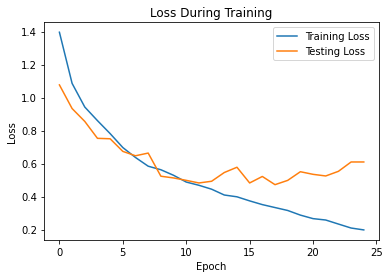

In [10]:
# === Plot the Data === #
plt.plot( history_dict['loss']     , label='Training Loss' )
plt.plot( history_dict['val_loss'] , label='Testing Loss' )

# === Label the Chart === #
plt.xlabel( 'Epoch' )
plt.ylabel( 'Loss' )
plt.title( 'Loss During Training' )
plt.legend( )

# === Display the Chart === #
plt.show( )

## Visualize Accuracy

This next cell shows a plot of the training and validation accuracy for the model (the exact results are saved in a future cell for later processing in another notebook.

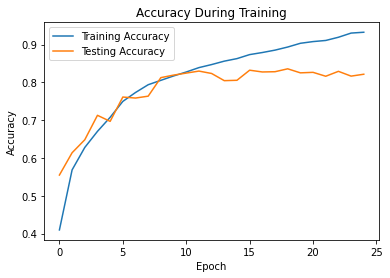

In [11]:
# === Plot the Data === #
plt.plot( history_dict['accuracy']     , label='Training Accuracy' )
plt.plot( history_dict['val_accuracy'] , label='Testing Accuracy'  )

# === Label the Chart === #
plt.xlabel( 'Epoch' )
plt.ylabel( 'Accuracy' )
plt.title( 'Accuracy During Training' )
plt.legend( )

# === Display the Chart === #
plt.show( )

## Save the Model 

Now that the model has been fully trained, we want to save the learned weights in order to be further evaluated later if needed. 

In [12]:
# === Save for Future Evaluation === #
hypermodel.save( 'SmallGrayReg_Results/TUNED_vgg19_intel_model.h5' )

## Display Runtimes

We will show the measured preprocessing overhead time and the training time of this program in order to gain an understanding of the behavior of this baseline application. These resutls are saved in a future slide for later processing in a different notebook. 

In [13]:
for t in times:
    print( '{}: {}s'.format( t['Event'] , round( t['Time (sec)'] , 4 ) ) )

Load/Process Dataset: 11.4666s
Hyperparameter Tuning: 805.6641s
Training: 988.3832s


## Save Time Data

The above data is converted into a pandas DataFrame for saving into a formatted CSV file. This csv file will be used for processing in a different notebook. 

In [14]:
time_data  = {
    'Event': [t['Event'] for t in times],
    'Time (sec)': [t['Time (sec)'] for t in times]
}
time_table = pd.DataFrame( time_data )
time_table.to_csv( 'SmallGrayReg_Results/TUNED_vgg19_intel_times.csv' , index=False )
time_table.head( )

,Event,Time (sec)
0,Load/Process Dataset,11.466614
1,Hyperparameter Tuning,805.664079
2,Training,988.383242


## Save Training/Validation Data

Finally, construct a pandas dataframe of the training loss, validation loss, training accuracy, and validation accuracy at each epoch during training. These values are saved for processing in a different notebook. 

In [15]:
model_data = {
    'Epoch': [i+1 for i in range(25)],
    'Training Accuracy': history_dict['accuracy'],
    'Validation Accuracy': history_dict['val_accuracy'],
    'Training Loss': history_dict['loss'],
    'Validation Loss': history_dict['val_loss']
}
model_table = pd.DataFrame( model_data )
model_table.to_csv( 'SmallGrayReg_Results/TUNED_vgg19_intel_history.csv' , index=False )
model_table.head( len( model_table ) )

,Epoch,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss
0,1,0.409862,0.555000,1.395757,1.076709
1,2,0.568619,0.614000,1.085883,0.933402
2,3,0.627975,0.648333,0.942551,0.855393
3,4,0.670514,0.713000,0.860132,0.752902
4,5,0.707710,0.697000,0.781502,0.750317
5,6,0.749822,0.761333,0.697097,0.673785
6,7,0.773336,0.758667,0.636762,0.647280
7,8,0.793929,0.763667,0.584054,0.663617
8,9,0.805544,0.812667,0.562547,0.523403
9,10,0.817087,0.819333,0.528974,0.512879
